In [145]:
# 0.0 import packages

import time
import sys
import string
import mido
import numpy as np
import pandas as pd

from scipy import signal
import audiosegment
import librosa
import shutil
import os

import matplotlib.pyplot as plot

In [146]:
# 0.1 midi mappings from groove dataset
# kick drum
BASS = 36
# snare drum
SNARE_HEAD = 38
SNARE_RIM = 40
SNARE_X_STICK = 37
# toms
TOM_1_HEAD = 48
TOM_1_RIM = 50
TOM_2_HEAD = 45
TOM_2_RIM = 47
TOM_3_HEAD = 43
TOM_3_RIM = 58
# hi-hats
HH_OPEN_BOW = 46
HH_OPEN_EDGE = 26
HH_CLOSED_BOW = 42
HH_CLOSED_EDGE = 22
HH_PEDAL = 44
# crash cymbal
CRASH_1_BOW = 49
CRASH_1_EDGE = 55
CRASH_2_BOW = 57
CRASH_2_EDGE = 52
# ride cymbal
RIDE_BOW = 51
RIDE_EDGE = 59
RIDE_BELL = 53

# mappings for our own training (9)
KICK = 0
SNARE = 1
HH_CLOSED = 2
HH_OPEN = 3
RIDE = 4
TOM_1 = 5
TOM_2 = 6
TOM_3 = 7
CRASH = 8
NUM_FEATS = 9

# groove mappings to our mappings
KICK_LIST = [BASS]
SNARE_LIST = [SNARE_HEAD, SNARE_RIM, SNARE_X_STICK]
HH_CLOSED_LIST = [HH_CLOSED_BOW, HH_CLOSED_EDGE, HH_PEDAL]
HH_OPEN_LIST = [HH_OPEN_BOW, HH_OPEN_EDGE]
RIDE_LIST = [RIDE_BOW, RIDE_EDGE, RIDE_BELL]
TOM_1_LIST = [TOM_1_HEAD, TOM_1_RIM]
TOM_2_LIST = [TOM_2_HEAD, TOM_2_RIM]
TOM_3_LIST = [TOM_3_HEAD, TOM_3_RIM]
CRASH_LIST = [CRASH_1_BOW, CRASH_1_EDGE, CRASH_2_BOW, CRASH_2_EDGE]


In [147]:
# 1.0 load groove dataset

groove_csv = pd.read_csv('groove/info.csv')
print("groove dataset:", len(groove_csv))

# get train, test, and validation sets
train_csv = []
test_csv = []
validation_csv = []

for index, row in groove_csv.iterrows():
    if str(row.audio_filename).lower() != "nan":
        split = row['split']
        if split == "train":
            train_csv.append(row)
        elif split == "test":
            test_csv.append(row)
        elif split == "validation":
            validation_csv.append(row)
        
print ("train: ", len(train_csv))
print ("test: ", len(test_csv))
print ("validation: ", len(validation_csv))

groove dataset: 1150
train:  846
test:  124
validation:  120


In [148]:
# 1.1 code to convert midi file to array
# https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        value = 1 if velocity > 0 else 0
        result[note-21] = value if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    # sums = all_arys.sum(axis=1)
    # ends = np.where(sums > 0)[0]
    return all_arys #[min(ends): max(ends)]

In [149]:
# 2.0 functions for feature and label extraction

default_sample_rate = 44100
predefined_length = 9.99 # had to make a bit smaller than 10 sec. because was sizing array to 1001 instead of 1000
tensor_size = 1000 # used for label tensor creation

# resets temp folder
def reset_temp_folder():
    if os.path.isfile('temp/'):
        shutil.rmtree('temp/', ignore_errors=True)
    if not os.path.exists('temp/'):
        os.mkdir('temp/')

# converts an audio file to log mel array
def audio_to_melspec_array(wav_file_path, sample_rate=default_sample_rate):
    window_size = 0.025
    window_stride = 0.01
    n_dft = int(sample_rate * window_size)
    n_mels = 128
    win_length = 1024
    hop_length = int(sample_rate * window_stride)
    # load in wav file and remove the mean of the signal
    y, sr = librosa.load(wav_file_path, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length, win_length=win_length, window=signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=n_mels, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    # plot.imshow(logspec.T, origin='lower', aspect='auto')
    # plot.show()
    # turn into tensor
    # logspec_tensor = torch.tensor(logspec)
    return logspec

# reformats midi array for training
def reformat_midi_for_training(midi_array):
    midi_array = midi_array.T # transpose midi array for easy access
    T_steps = midi_array.shape[1] # get number of time steps
    # kicks
    kick_midi = np.zeros((T_steps), dtype='int64')
    for val in KICK_LIST:
        kick_midi += midi_array[val-21]
    kick_midi = np.where(kick_midi > 0, 1, 0)
    # snares
    snare_midi = np.zeros((T_steps), dtype='int64')
    for val in SNARE_LIST:
        snare_midi += midi_array[val-21]
    snare_midi = np.where(snare_midi > 0, 1, 0)
    # hh_close
    hh_close_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_CLOSED_LIST:
        hh_close_midi += midi_array[val-21]
    hh_close_midi = np.where(hh_close_midi > 0, 1, 0)
    # hh_open
    hh_open_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_OPEN_LIST:
        hh_open_midi += midi_array[val-21]
    hh_open_midi = np.where(hh_open_midi > 0, 1, 0)
    # ride
    ride_midi = np.zeros((T_steps), dtype='int64')
    for val in RIDE_LIST:
        ride_midi += midi_array[val-21]
    ride_midi = np.where(ride_midi > 0, 1, 0)
    # tom 1
    tom1_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_1_LIST:
        tom1_midi += midi_array[val-21]
    tom1_midi = np.where(tom1_midi > 0, 1, 0)
    # tom 2
    tom2_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_2_LIST:
        tom2_midi += midi_array[val-21]
    tom2_midi = np.where(tom2_midi > 0, 1, 0)
    # tom 3
    tom3_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_3_LIST:
        tom3_midi += midi_array[val-21]
    tom3_midi = np.where(tom3_midi > 0, 1, 0)
    # crash
    crash_midi = np.zeros((T_steps), dtype='int64')
    for val in CRASH_LIST:
        crash_midi += midi_array[val-21]
    crash_midi = np.where(crash_midi > 0, 1, 0)
    
    reformated_midi_array = np.zeros((midi_array.shape[1], NUM_FEATS), dtype='int64')
    reformated_midi_array[:,KICK] = kick_midi
    reformated_midi_array[:,SNARE] = snare_midi
    reformated_midi_array[:,HH_CLOSED] = hh_close_midi
    reformated_midi_array[:,HH_OPEN] = hh_open_midi
    reformated_midi_array[:,RIDE] = ride_midi
    reformated_midi_array[:,TOM_1] = tom1_midi
    reformated_midi_array[:,TOM_2] = tom2_midi
    reformated_midi_array[:,TOM_3] = tom3_midi
    reformated_midi_array[:,CRASH] = crash_midi
    # reformated_midi_array = np.vstack([
    #     kick_midi,
    #     snare_midi,
    #     hh_close_midi,
    #     hh_open_midi,
    #     ride_midi,
    #     tom1_midi,
    #     tom2_midi,
    #     tom3_midi,
    #     crash_midi
    # ])
    # reformated_midi_array = np.array(reformated_midi_array.T, dtype='int64')
    
    # print ("hh_open_midi.shape: ", hh_open_midi.shape)
    # print ("hh_open_midi: ", hh_open_midi)
    
    return reformated_midi_array

# shrinks an array down keeping the distance between values proportional
def shrink_array_proportionally(midi_array, target_resize):
    resized_array = np.zeros((target_resize, midi_array.shape[1]))
    ratio = midi_array.shape[0] / target_resize
    # iterate through each time-step
    for t in range(midi_array.shape[0]): 
        # for each value
        for i in range(midi_array.shape[1]):
            value = midi_array[t][i]
            if value > 0:
                t2 = int(t / ratio)
                resized_array[t2][i] = value
    return resized_array

# converts a midi array to a list of arrays
def midi_to_arrays(midi_array, num_arrays):
    midi_arrays = []
    split_midi_arrays = np.array_split(midi_array, num_arrays)
    #print ("midi array len: ", len(midi_array))
    #print ("split list len: ", len(split_midi_arrays))
    for i in range(len(split_midi_arrays)):
        #print ("shape: ", split_midi_arrays[i].shape)
        # only add array if correct size
        if split_midi_arrays[i].shape == (tensor_size, NUM_FEATS):
            midi_arrays.append(split_midi_arrays[i])
    return midi_arrays

def show_midi_plot(midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    f = plot.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    plot.imshow(midi_array, cmap='binary', interpolation='nearest', aspect="auto")
    plot.show()
    
def show_spectrograph(spec_array):
    spec_array = np.flip(spec_array.T, axis=0)
    f = plot.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    plot.imshow(spec_array, cmap='magma', interpolation='nearest', aspect="auto")
    plot.show()
    
def show_midi_over_spec(spec_array, midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    spec_array = np.flip(spec_array.T, axis=0)
    fig = plot.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    plot.imshow(spec_array, 'magma', interpolation='nearest', aspect="auto")
    plot.imshow(midi_array, 'binary', interpolation='nearest', alpha=0.5, aspect="auto")
    plot.show()


def index_to_arrays(csv_index):
    # load in wav file
    audio_file_path = "groove/" + csv_index.audio_filename
    wav_file = audiosegment.from_file(audio_file_path)
    #print ("sample rate: ", wav_file.frame_rate)
    #print ("wav duration: ", wav_file.duration_seconds)
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # cutting and padding
    diced_wav_files = wav_file.dice(predefined_length, zero_pad=False)
    #print ("diced wav files len: ", len(diced_wav_files))
    target_len = predefined_length * wav_file.frame_rate
    feats_list = []
    zeros_padded_sec = 0
    i = 0
    for diced_file in diced_wav_files:
        # pad with zeros if not correct length
        diced_file_len = len(diced_file.to_numpy_array())
        #print ("\tdiced file len: ", diced_file_len)
        if diced_file_len != target_len:
            zeros = int(target_len - diced_file_len)
            zeros_padded_sec = (zeros / target_len) * predefined_length
            print ("zeros_padded_sec: ", zeros_padded_sec)
            diced_array = np.pad(diced_file.to_numpy_array(), (0, zeros))
            diced_file = audiosegment.from_numpy_array(diced_array, framerate=default_sample_rate)
        # export temp wav file and convert to tensor
        diced_file_path = str(csv_index.id) + "-" + str(i) + ".wav"
        diced_file_path = diced_file_path.replace('/', '-')
        diced_file_path = "temp/" + diced_file_path
        diced_file.export(diced_file_path, format="wav")
        feats_array = audio_to_melspec_array(diced_file_path, wav_file.frame_rate)
        feats_list.append(feats_array)
        i += 1
    # return numpy array
    feats_list = np.array(feats_list, dtype='float64')
    
    # load in midi file
    midi_file_path = "groove/" + csv_index.midi_filename
    midi = mido.MidiFile(midi_file_path)

    # convert midi to arrray
    midi_array = mid2array(midi)
    #show_midi_plot(midi_array)
    
    # reformat midi array for training
    midi_array = reformat_midi_for_training(midi_array)
    #show_midi_plot(midi_array)
    #print ("reformated midi_array.shape: ", midi_array.shape)


    # resize array to be directly related to duration of the audio file (every second is 100 units)
    target_resize = int(wav_file.duration_seconds * 100)
    #print ("current midi array size: ", midi_array.shape[0], " target size: ", target_resize)
    midi_array = shrink_array_proportionally(midi_array, target_resize)
    #show_midi_plot(midi_array)
    #print ("shrinked midi_array.shape: ", midi_array.shape)
    
    # pad midi array to be proportionally same length as wav file w padded zeros 
    target_midi_length = len(feats_list) * tensor_size
    zeros = target_midi_length - len(midi_array)
    if zeros > 0:
        zeros_pad = np.zeros((zeros, midi_array.shape[1]))
        midi_array = np.concatenate((midi_array, zeros_pad))
        #print ("padded midi_array.shape: ", midi_array.shape)
    #show_midi_plot(midi_array)

    # create label arrays
    labels_list = midi_to_arrays(midi_array, len(feats_list))
    # return numpy arrays
    labels_list = np.array(labels_list, dtype='int64')
    
    #print ("feats: ", feats_list.shape)
    #print ("labels: ", labels_list.shape)
    
    return feats_list , labels_list

starting training dataset creation...
0  file:  drummer1/session1/1_funk_80_beat_4-4.wav   86.704688  sec
zeros_padded_sec:  2.9451473922902496


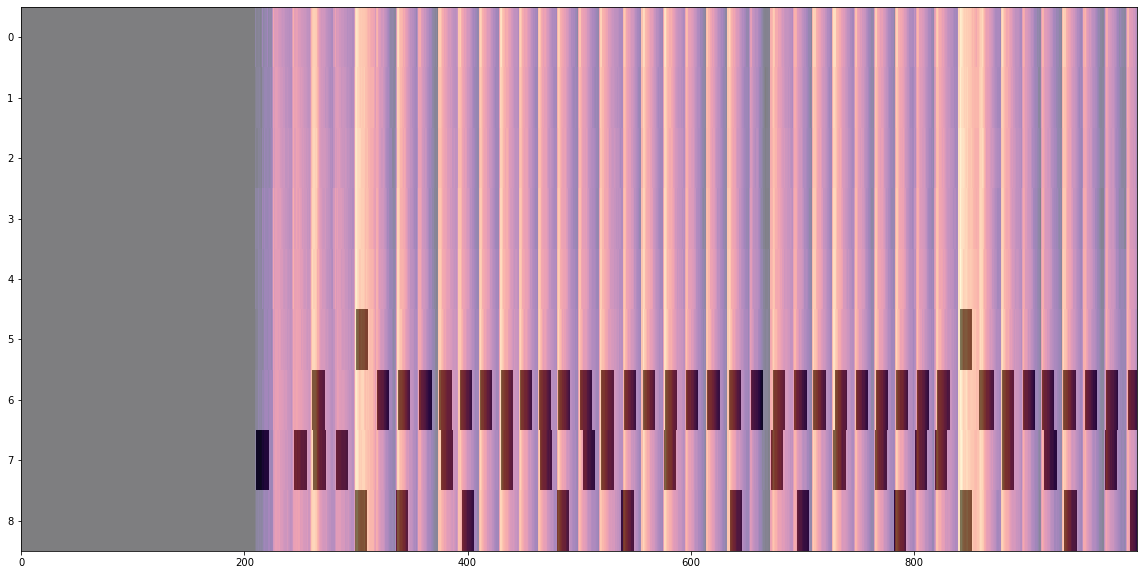

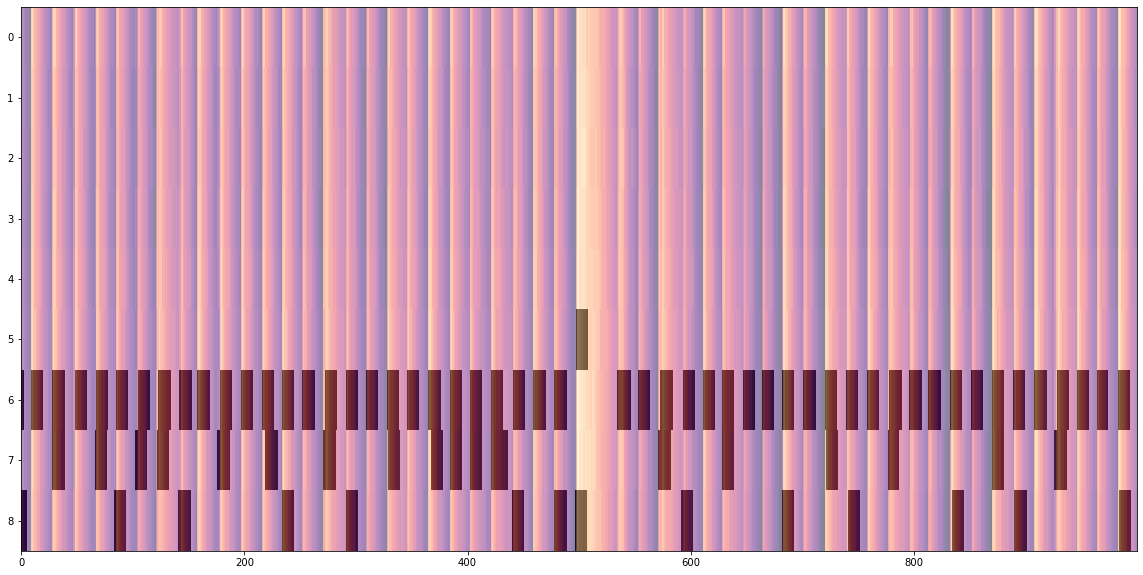

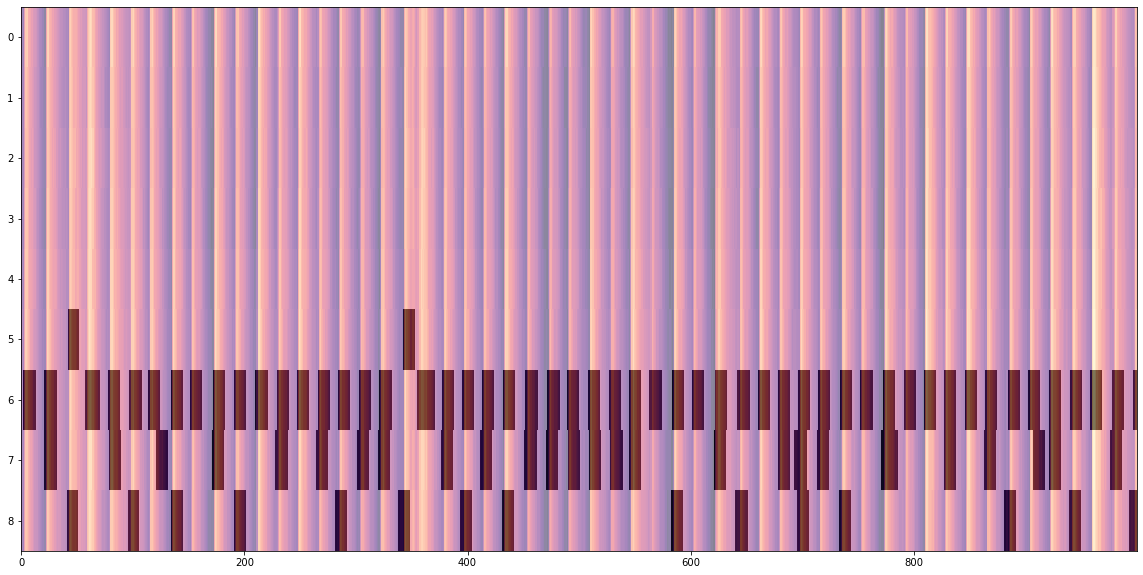

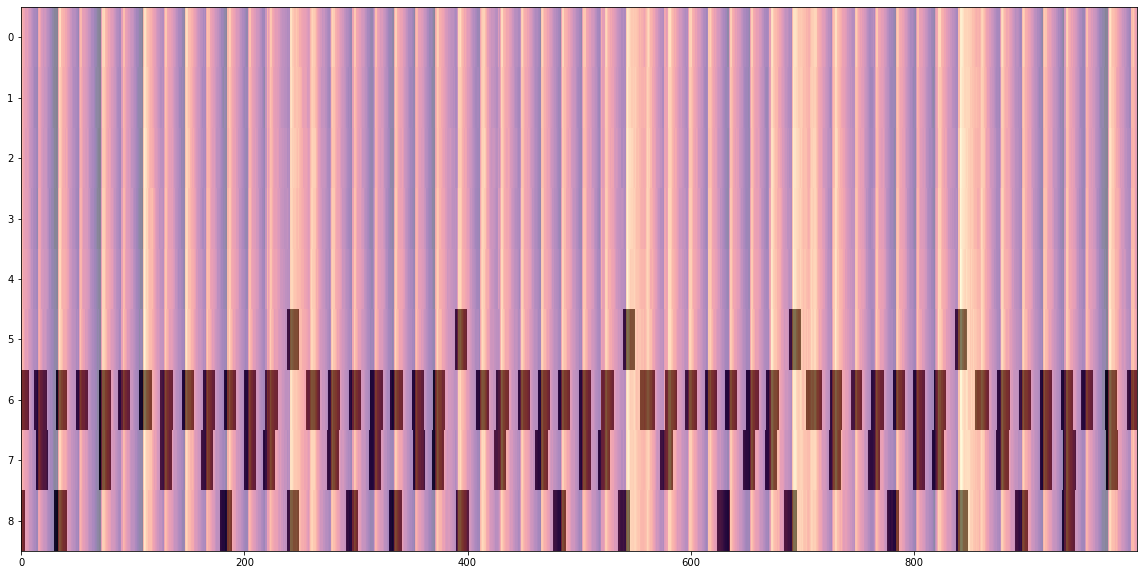

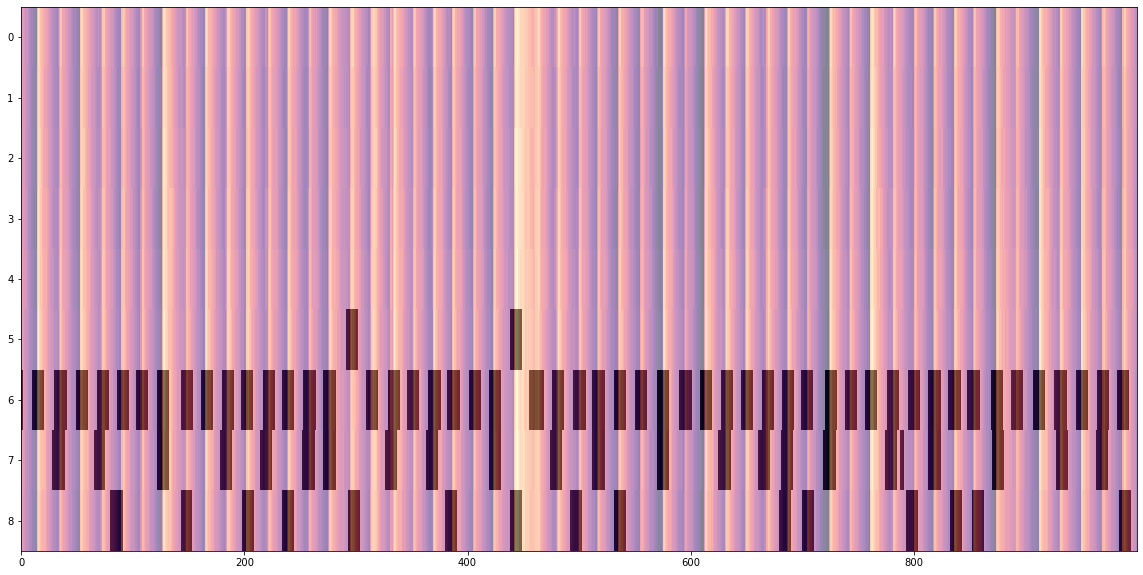

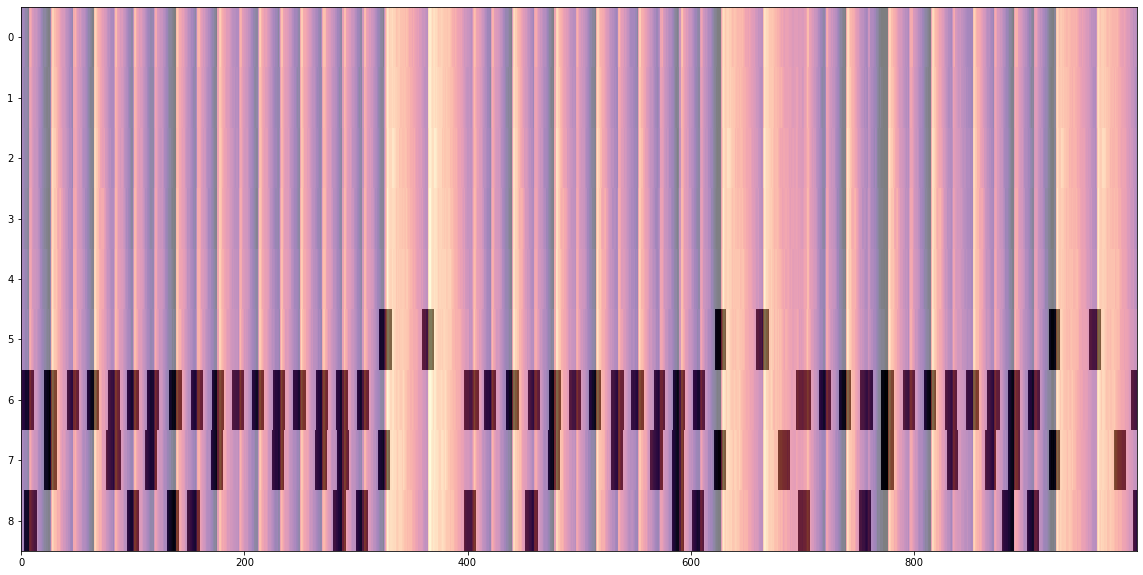

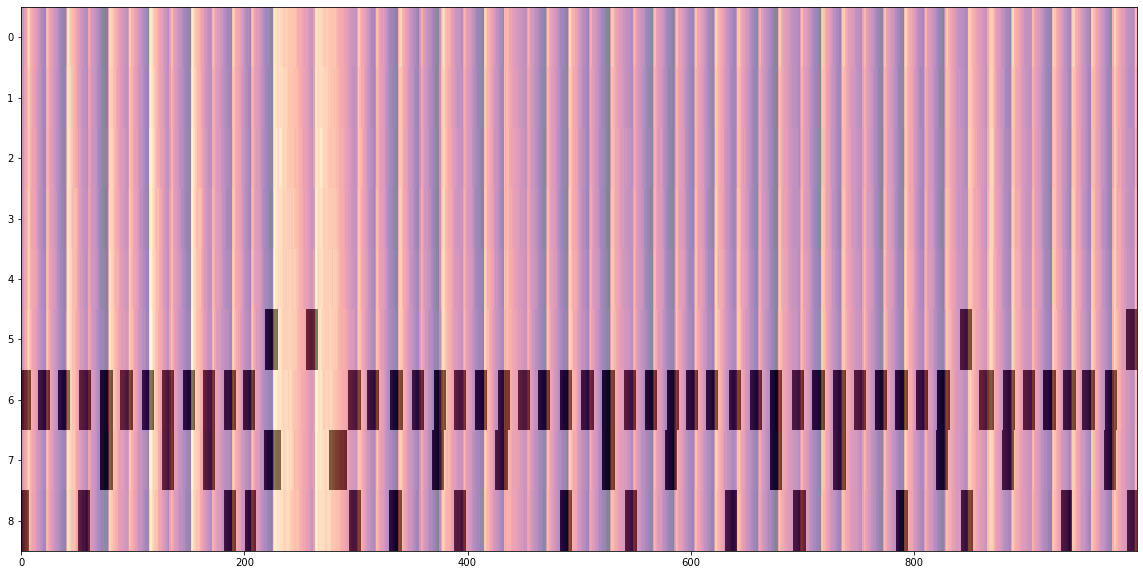

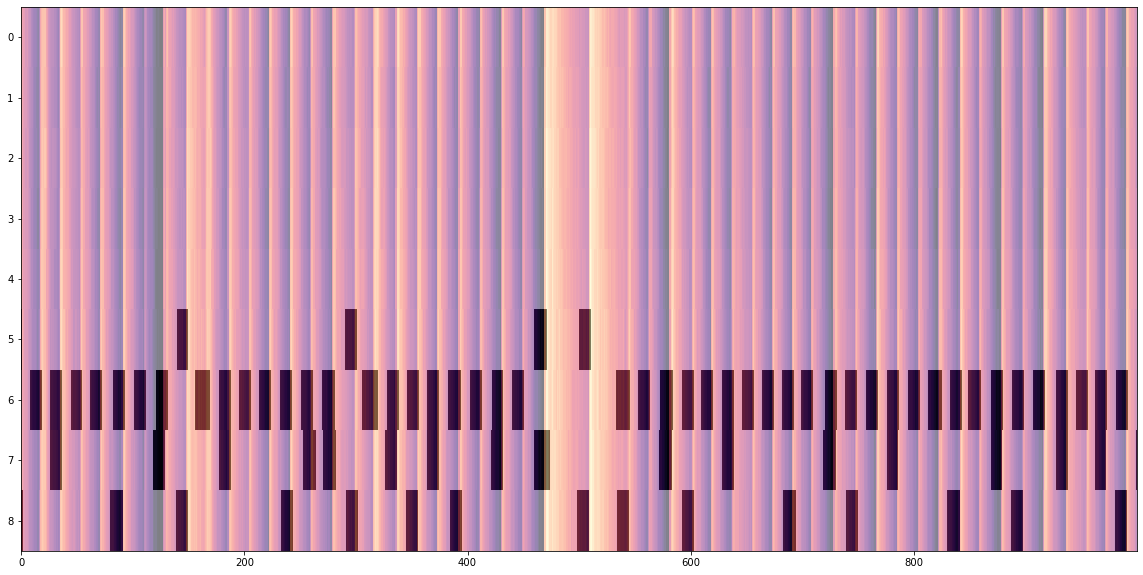

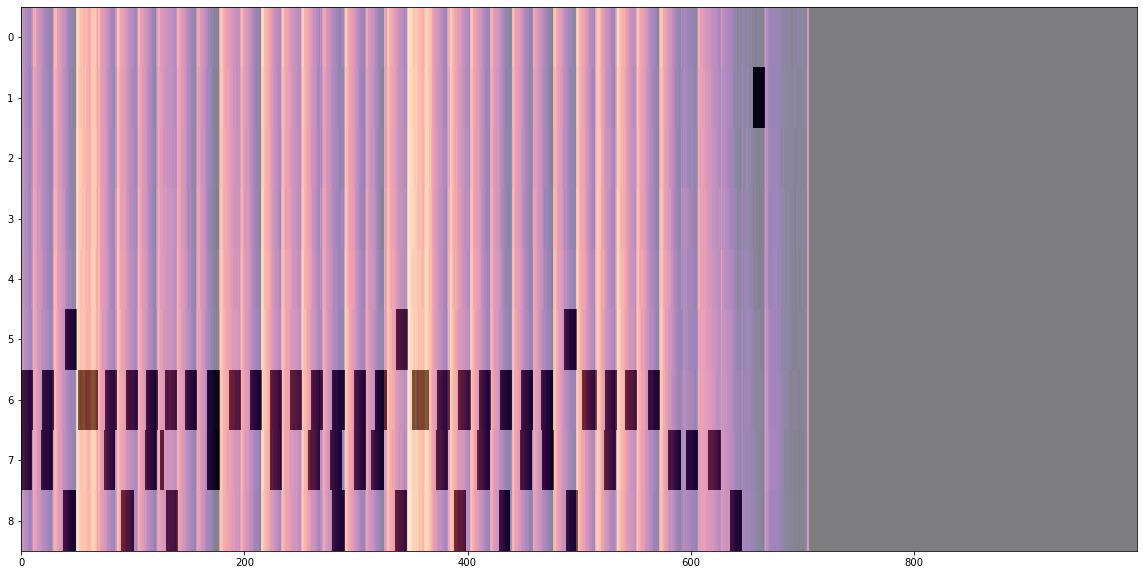

1  file:  drummer1/session1/10_jazz-funk_116_fill_4-4.wav   1.872843  sec
zeros_padded_sec:  7.921043083900226


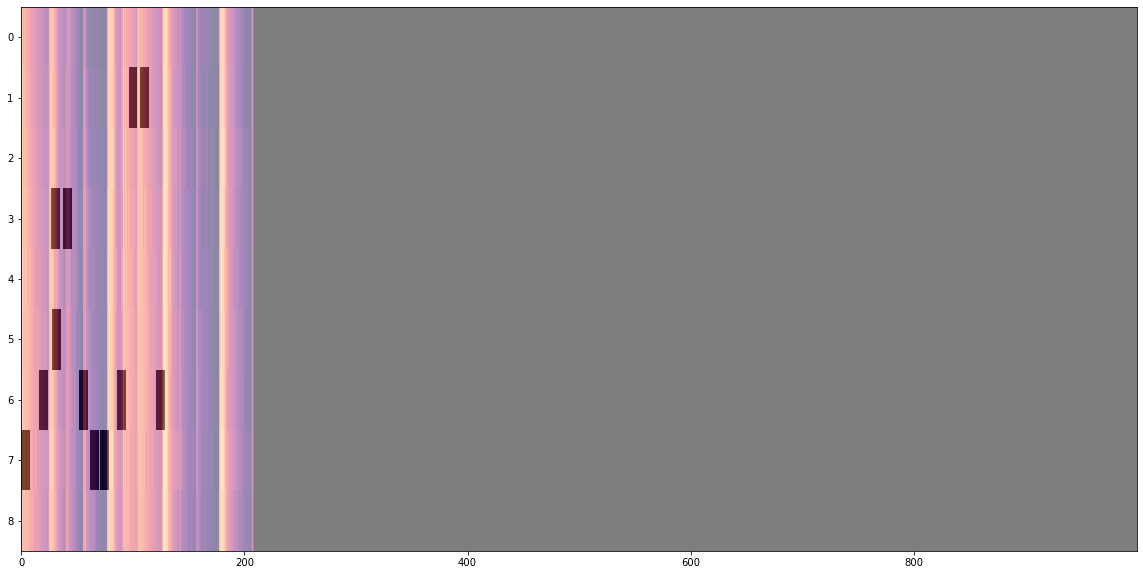

2  file:  drummer1/session1/100_neworleans-secondline_94_beat_4-4.wav   135.365719  sec
zeros_padded_sec:  4.5410204081632655


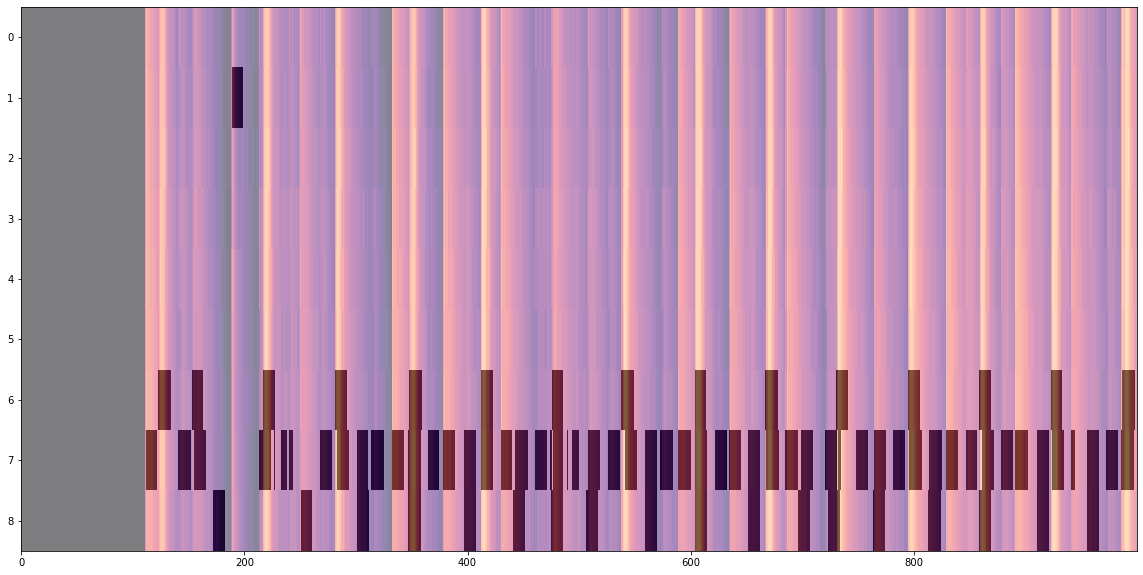

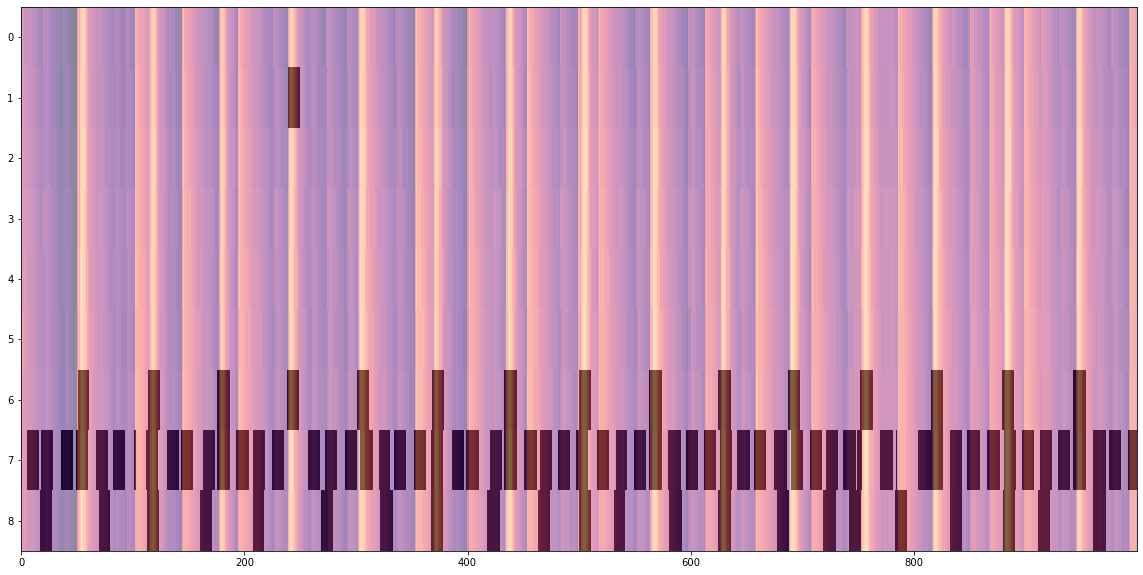

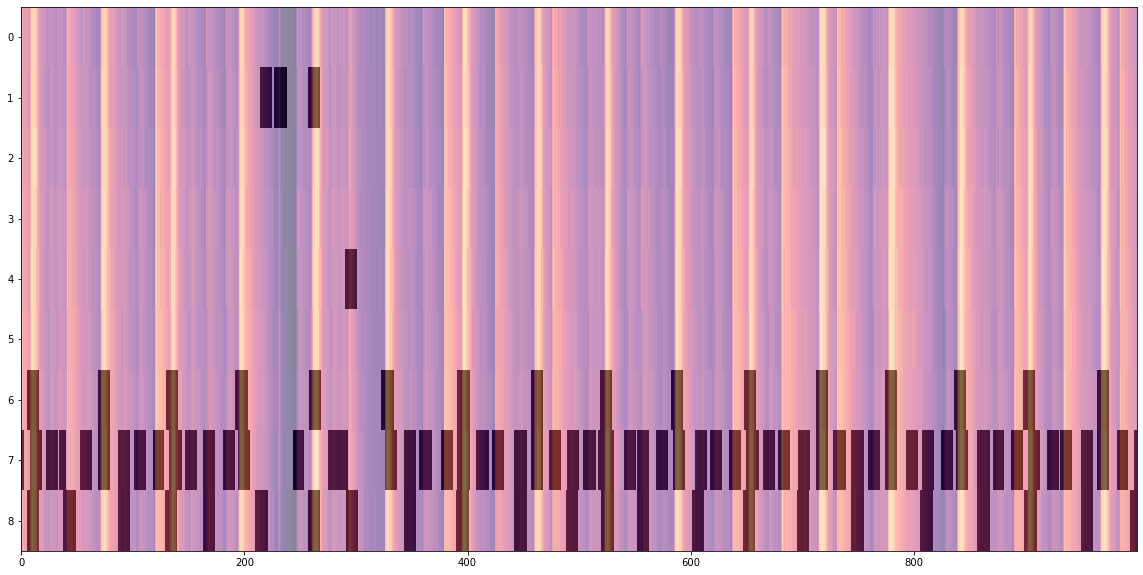

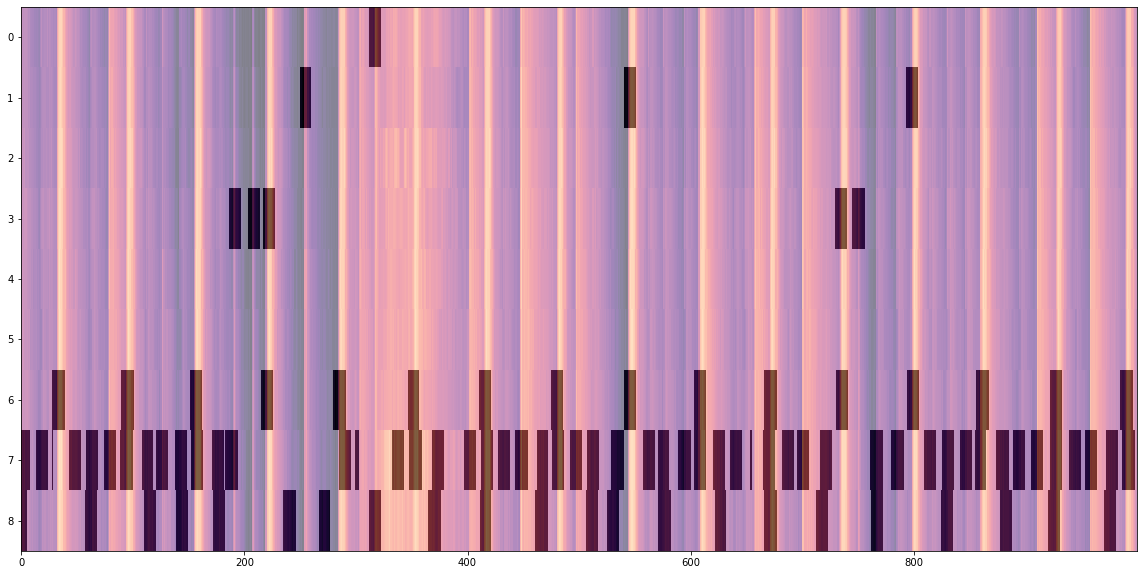

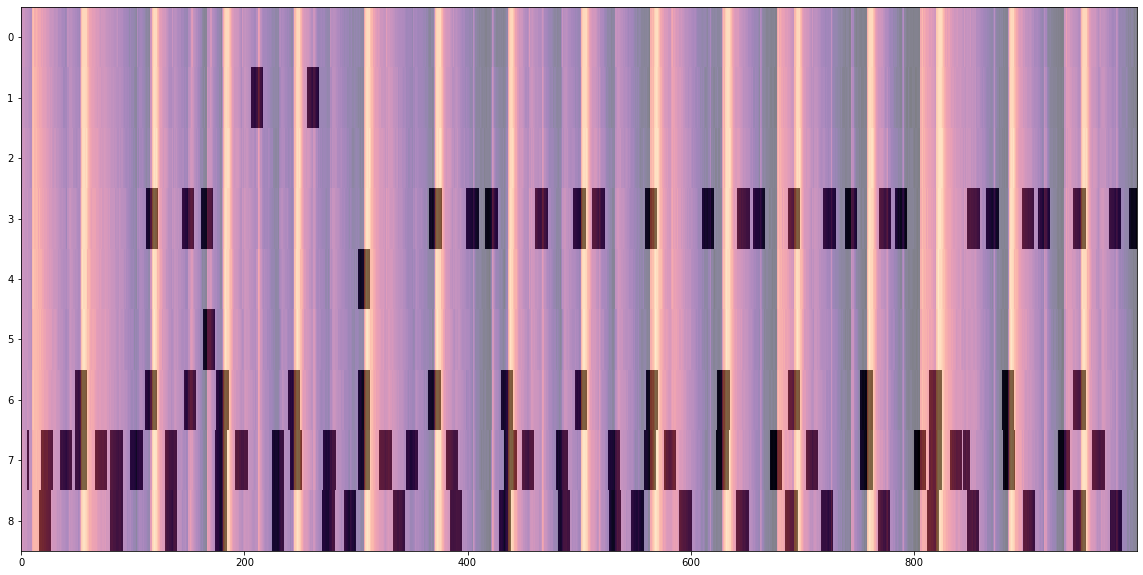

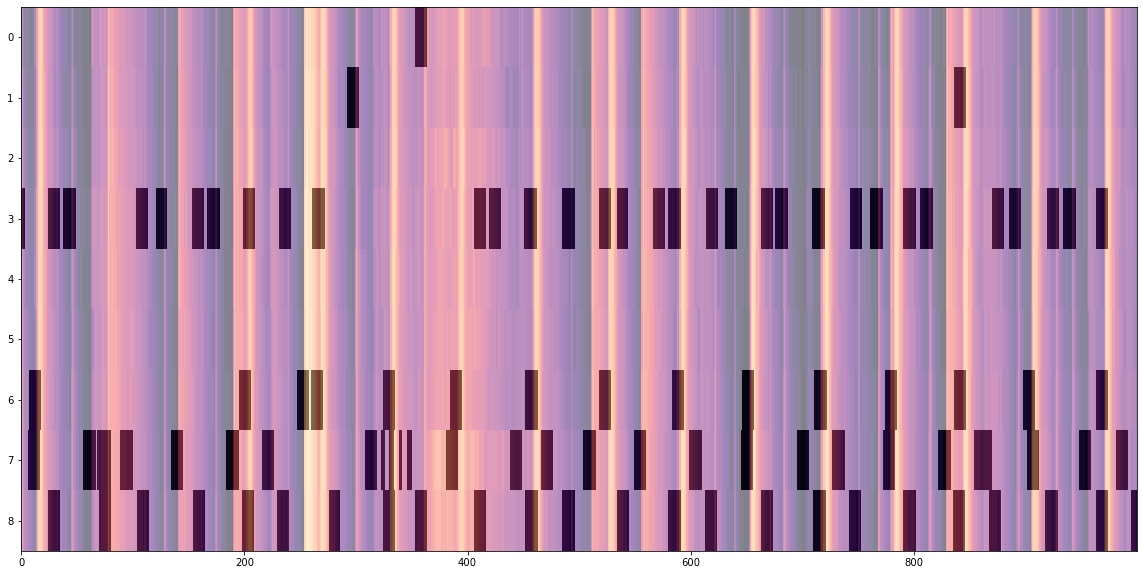

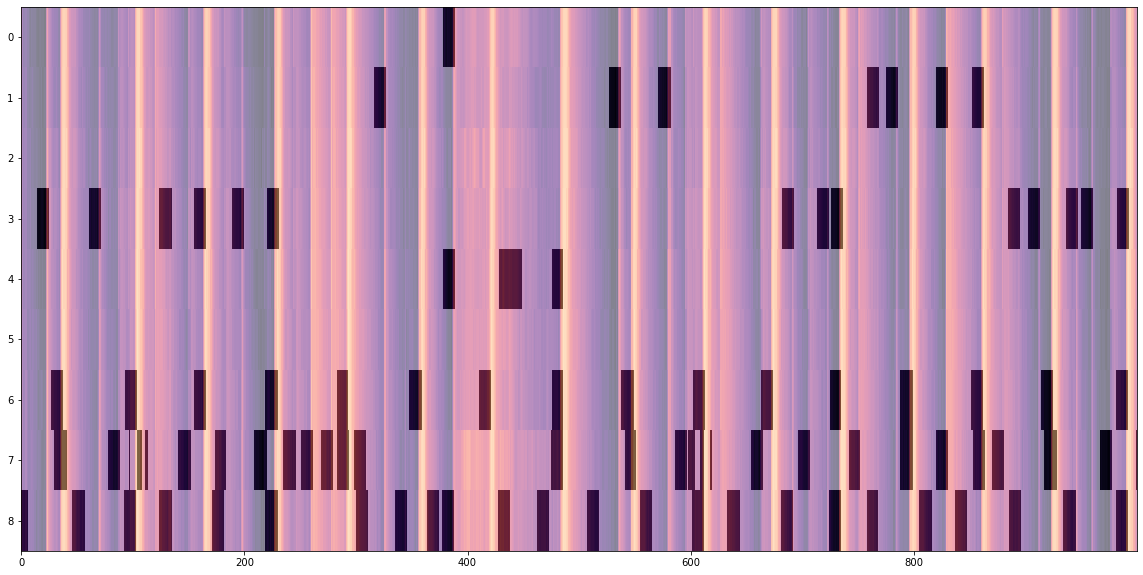

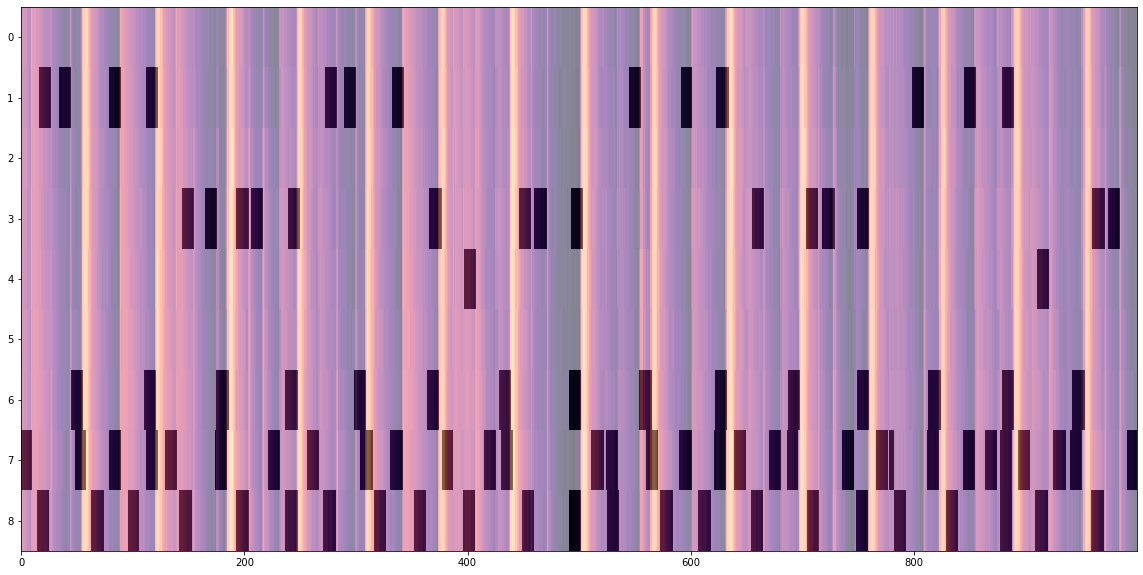

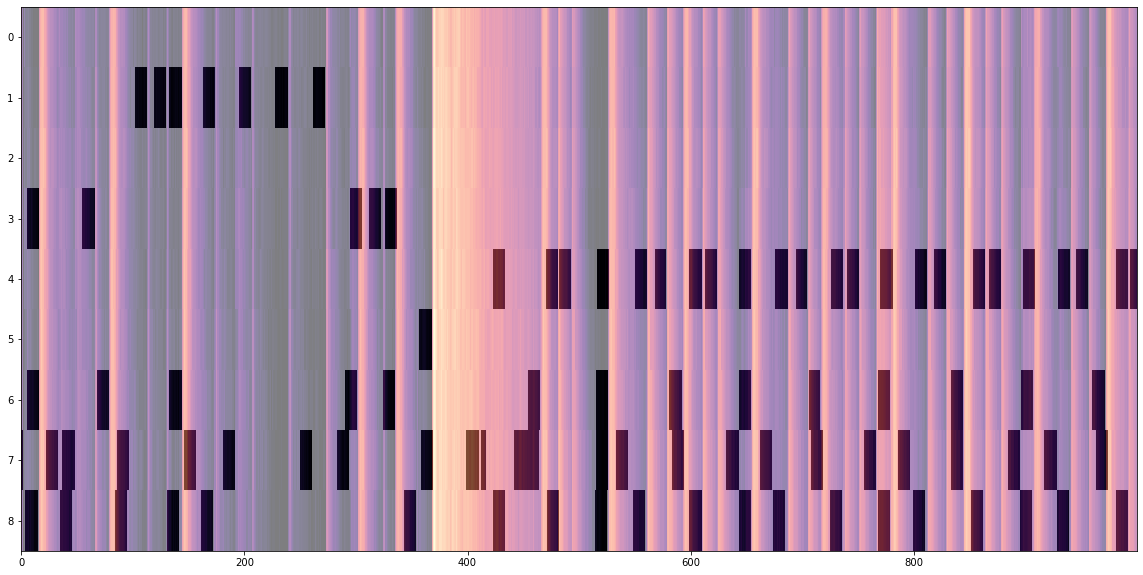

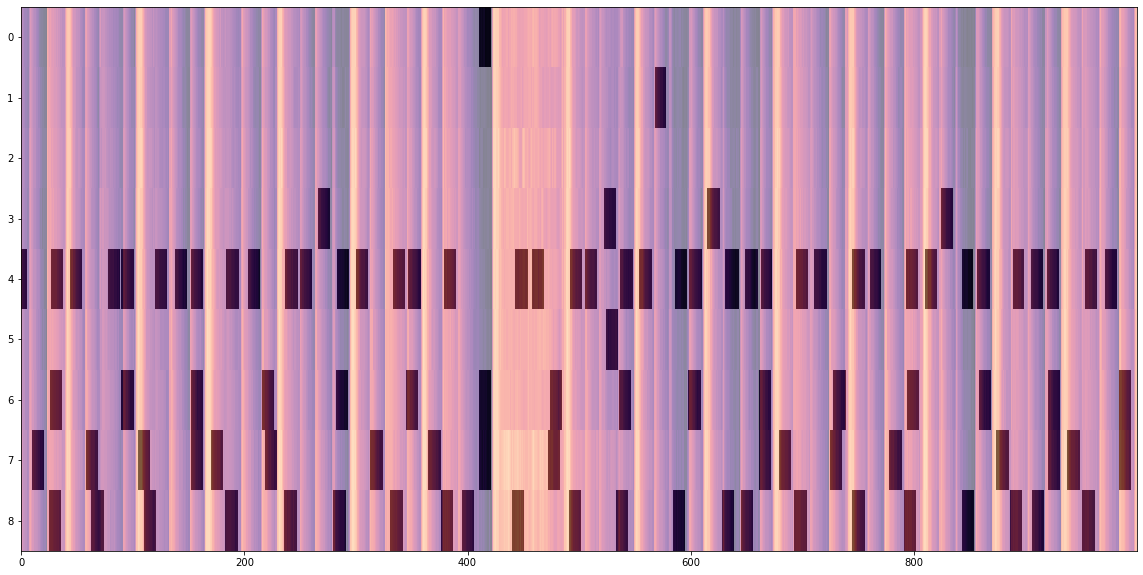

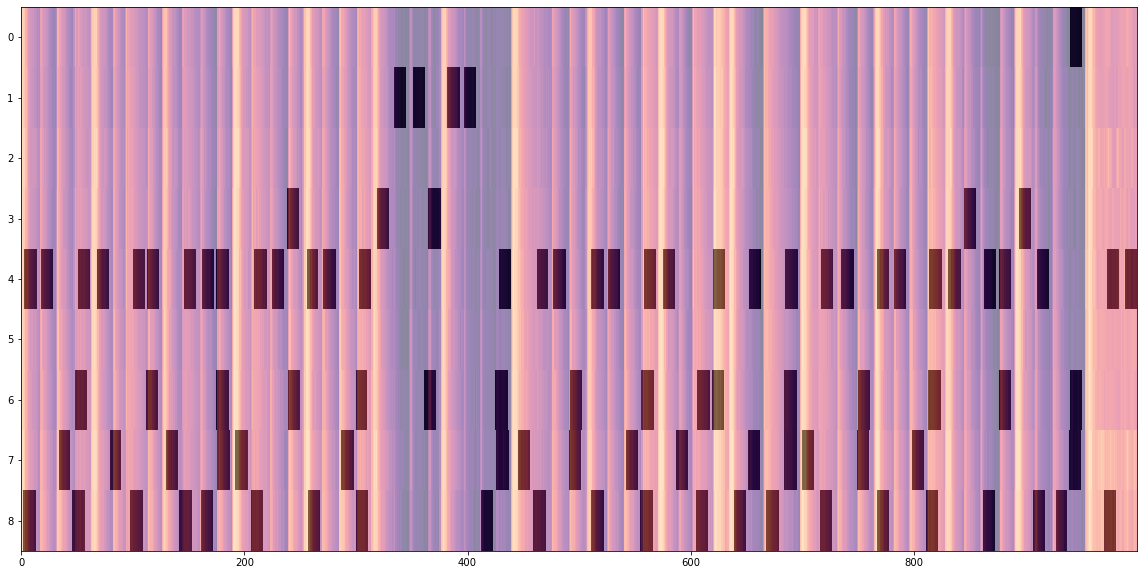

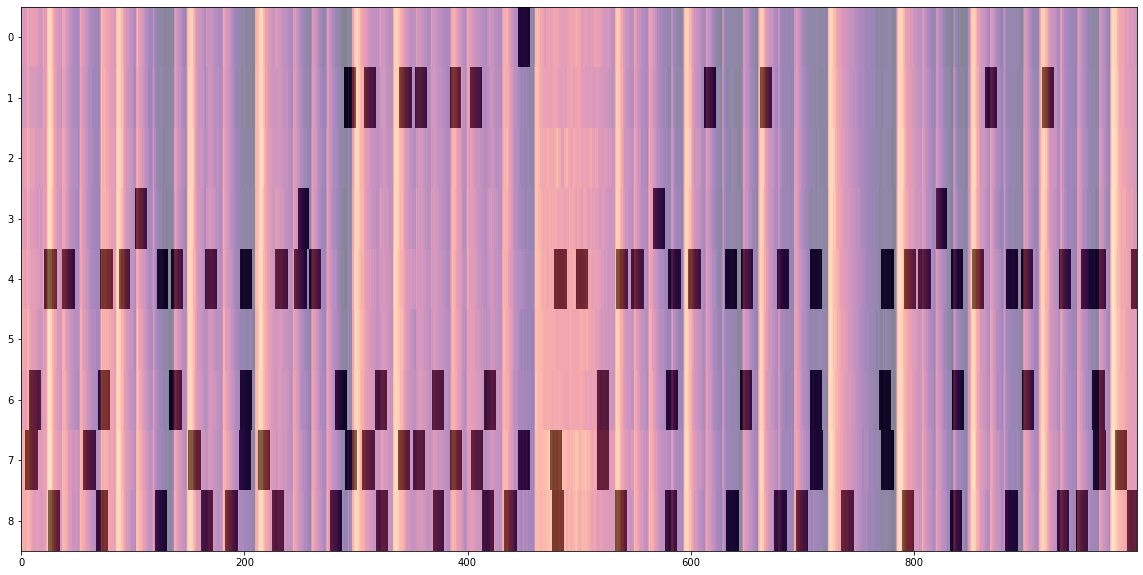

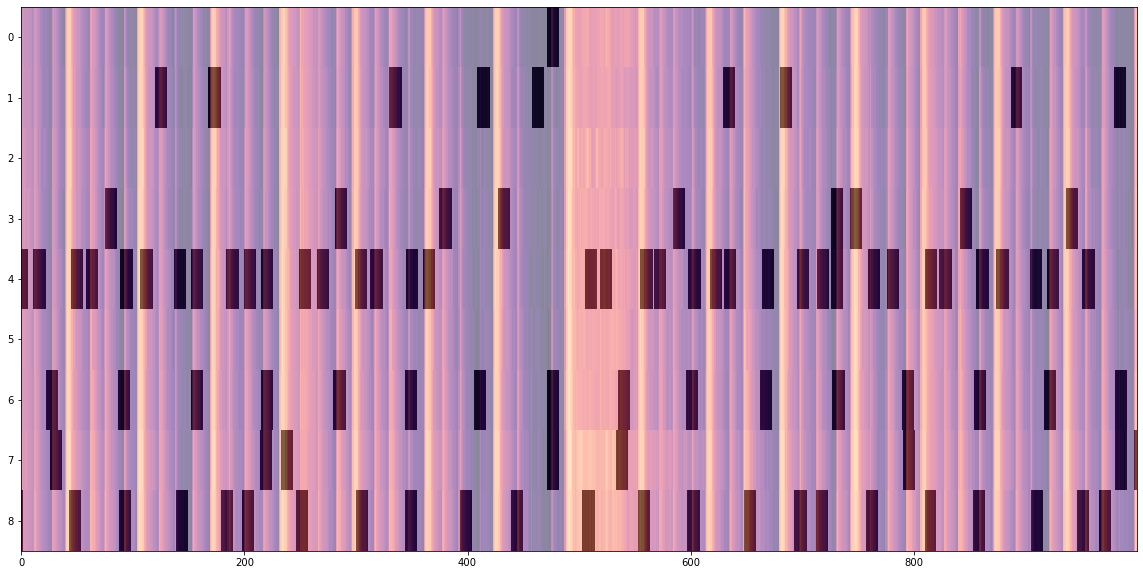

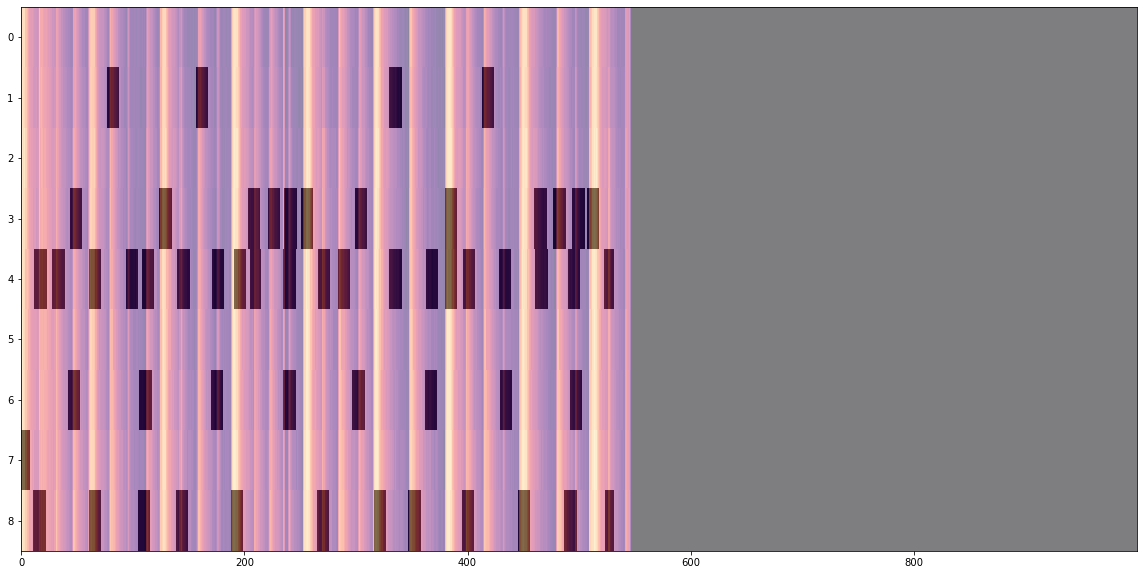

3  file:  drummer1/session1/101_dance-disco_120_beat_4-4.wav   207.572917  sec
zeros_padded_sec:  1.8380045351473924


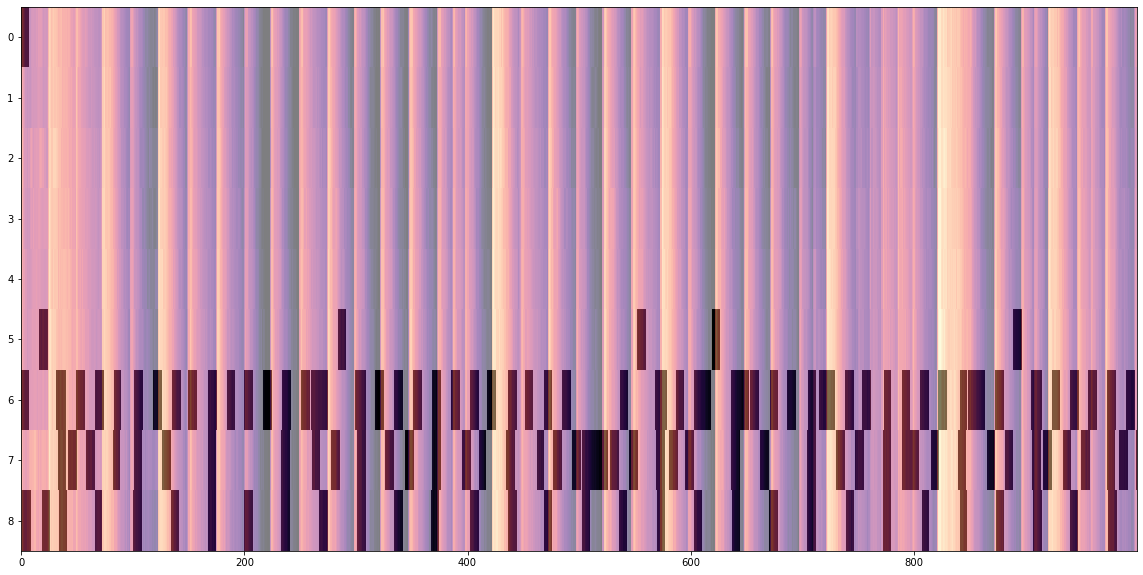

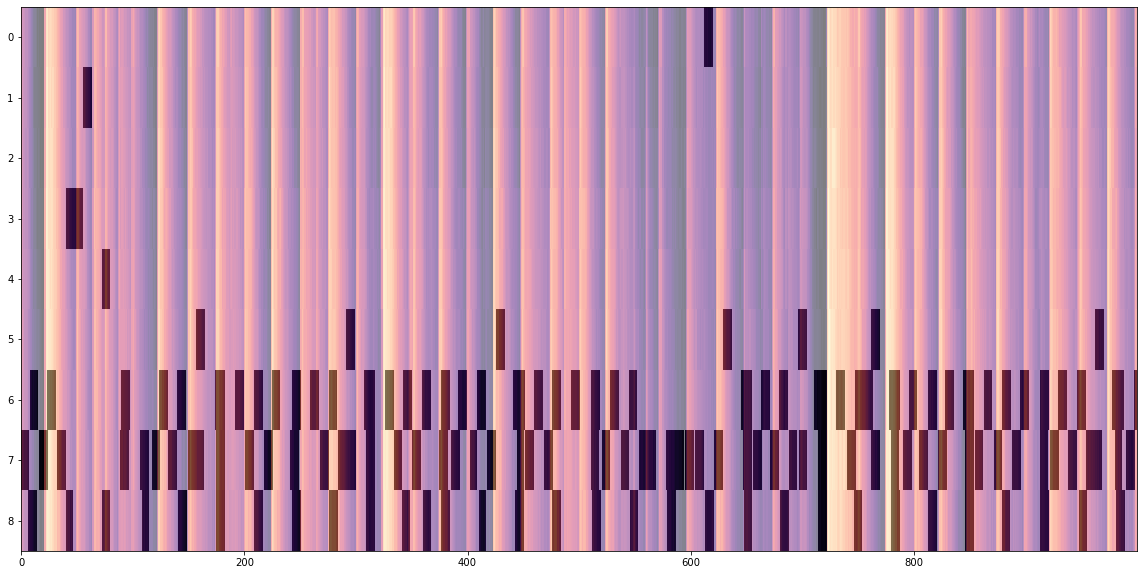

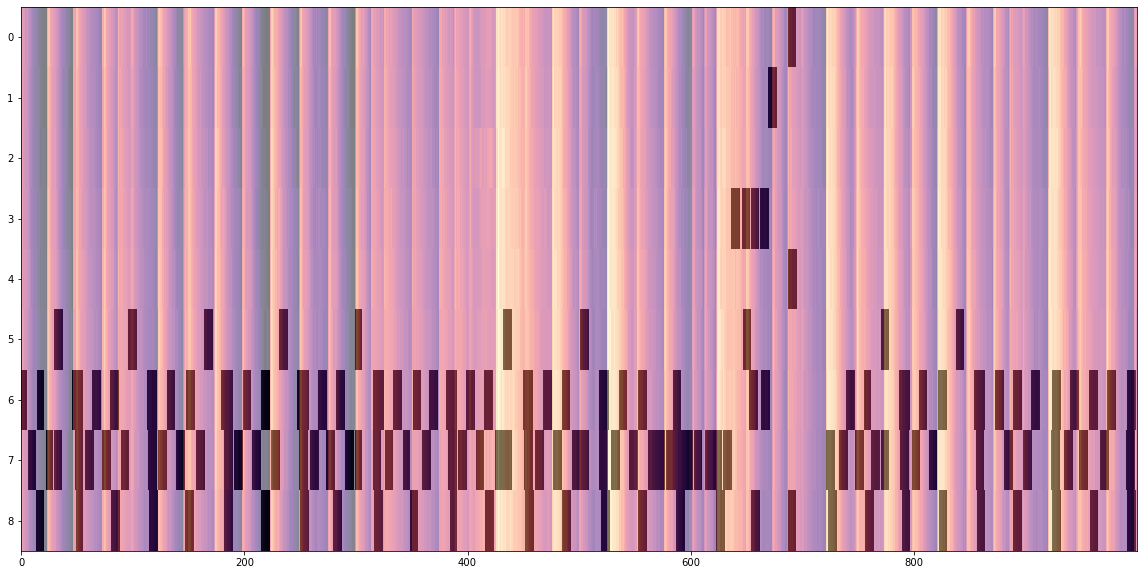

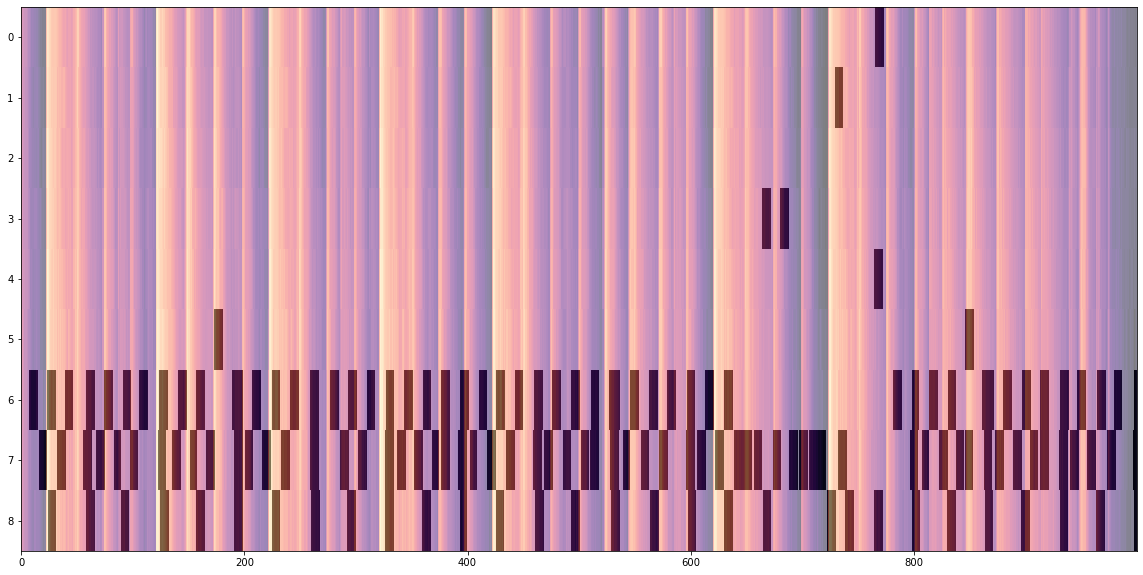

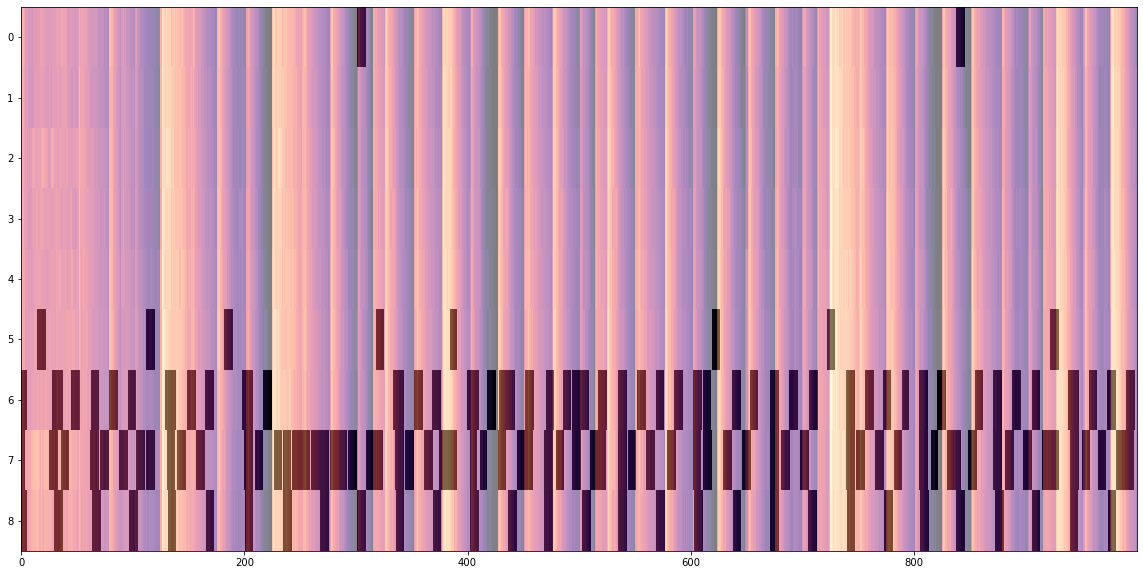

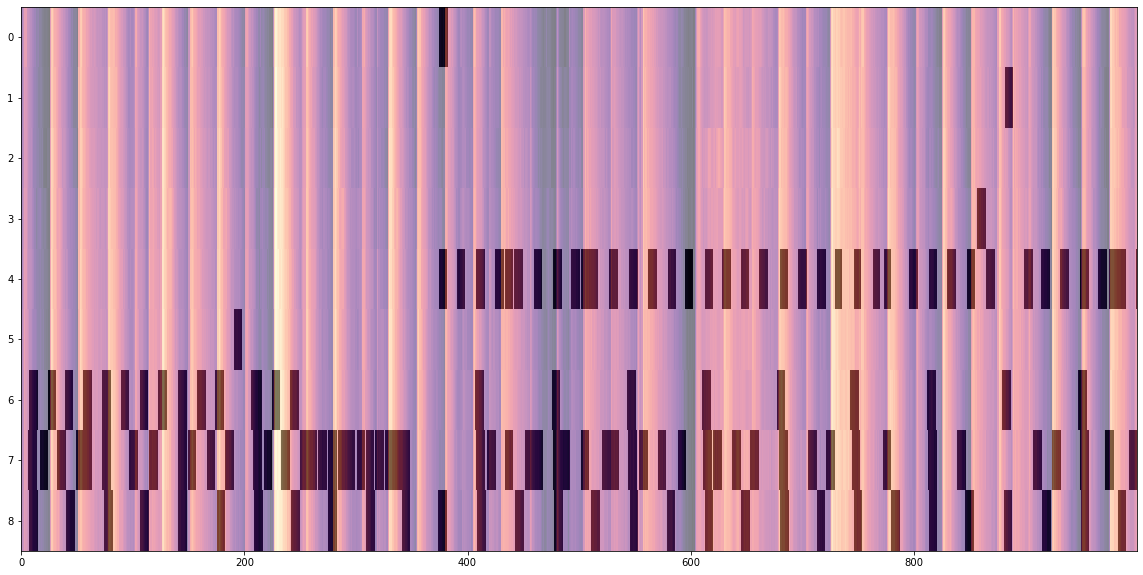

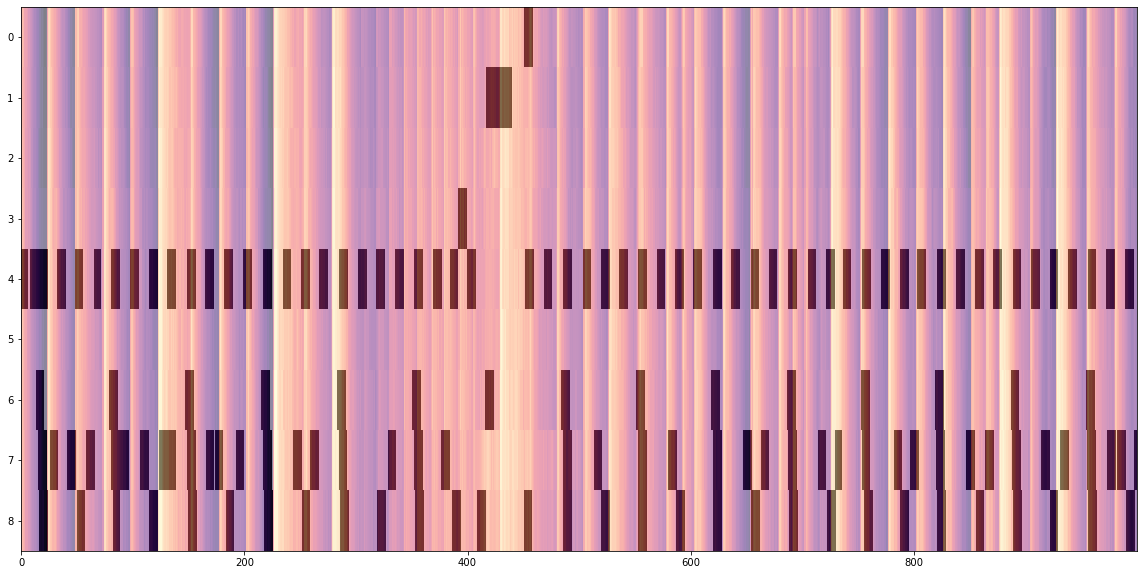

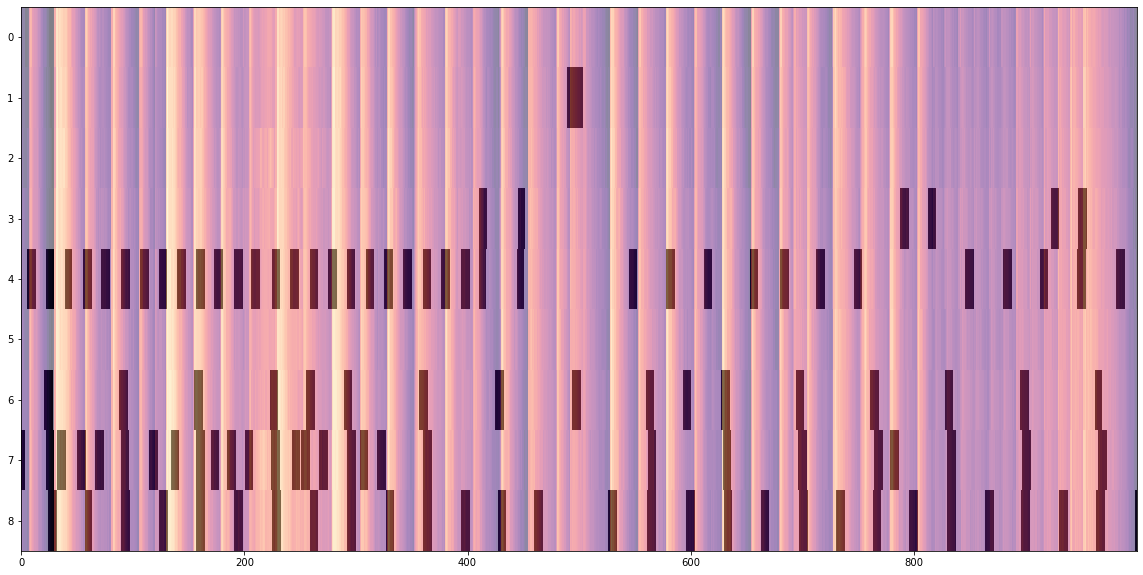

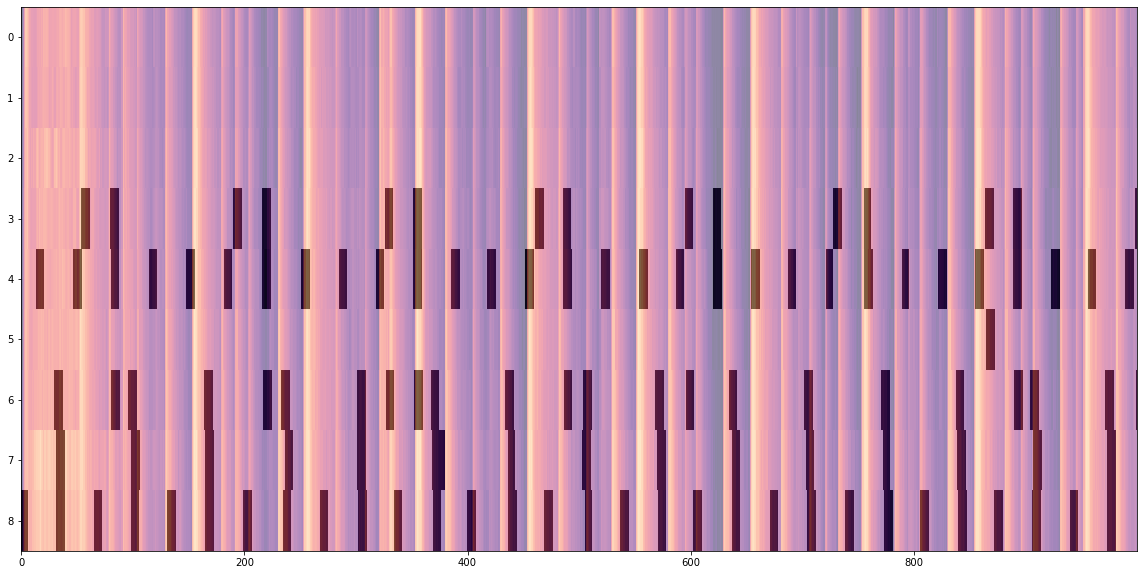

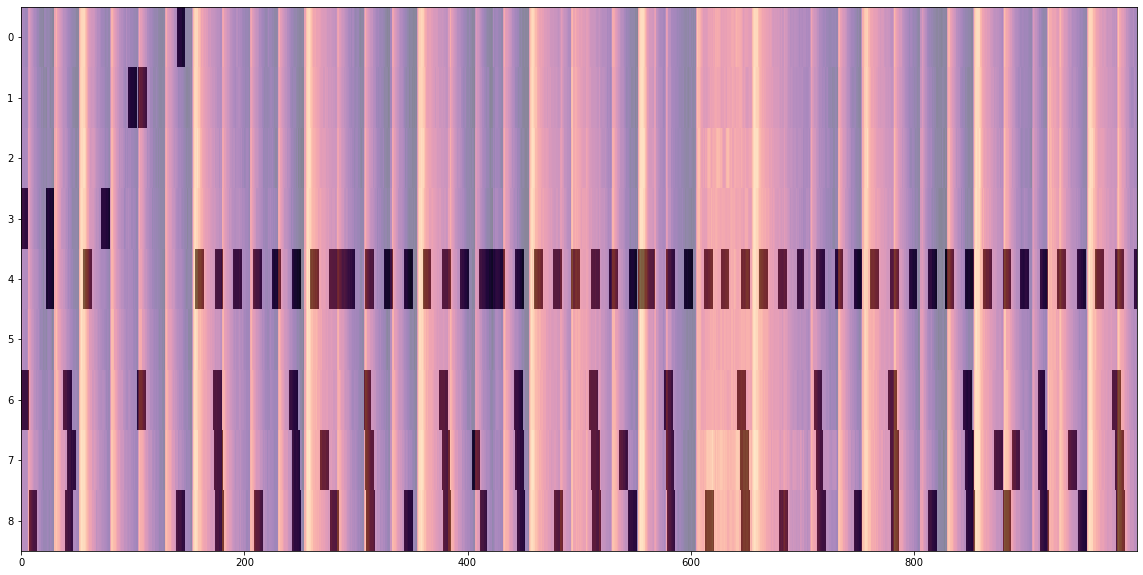

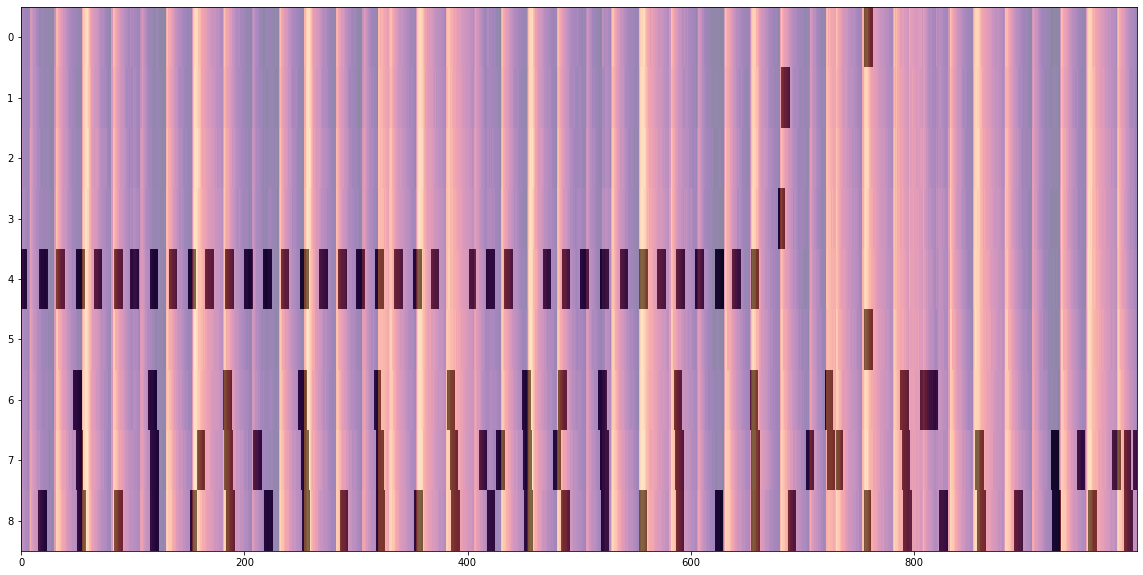

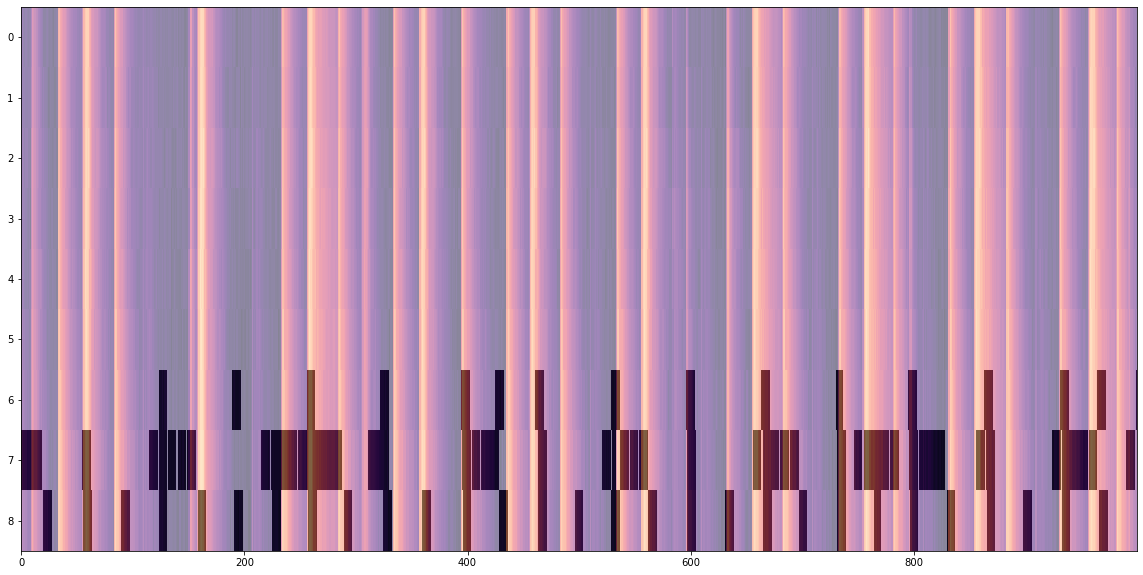

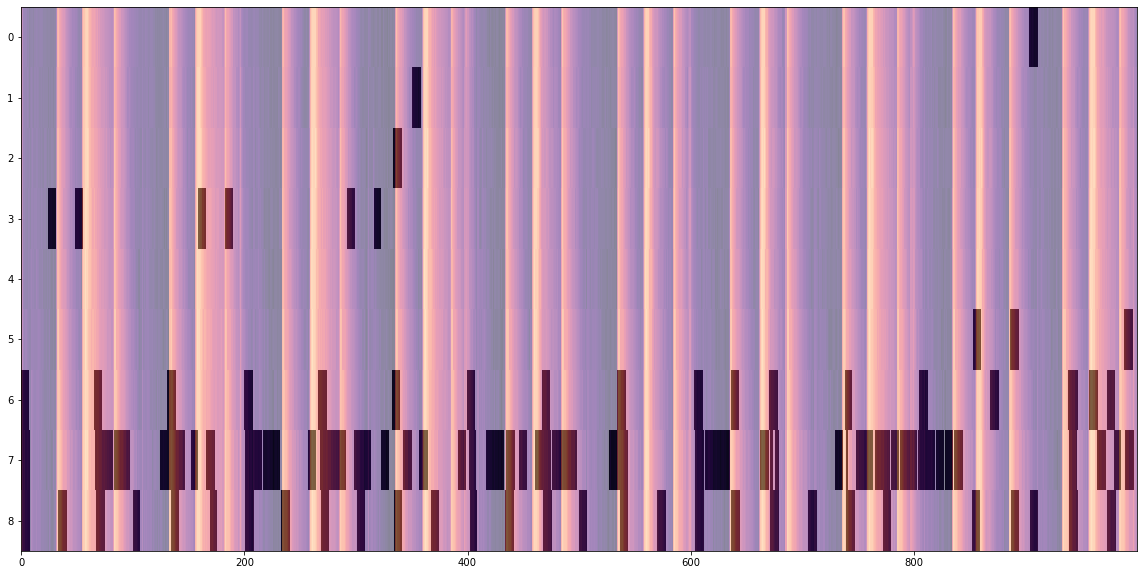

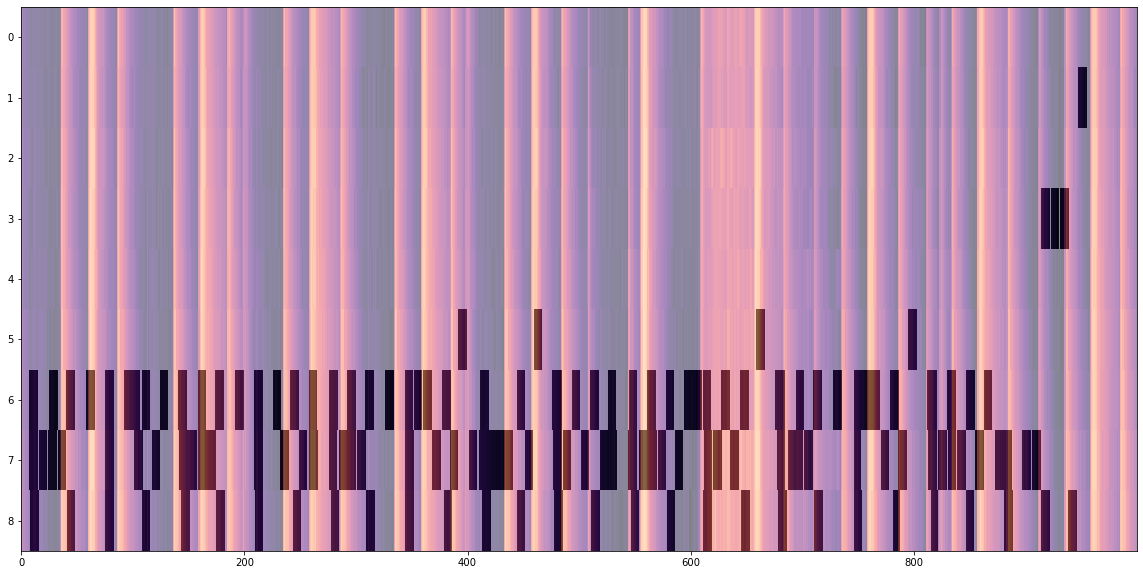

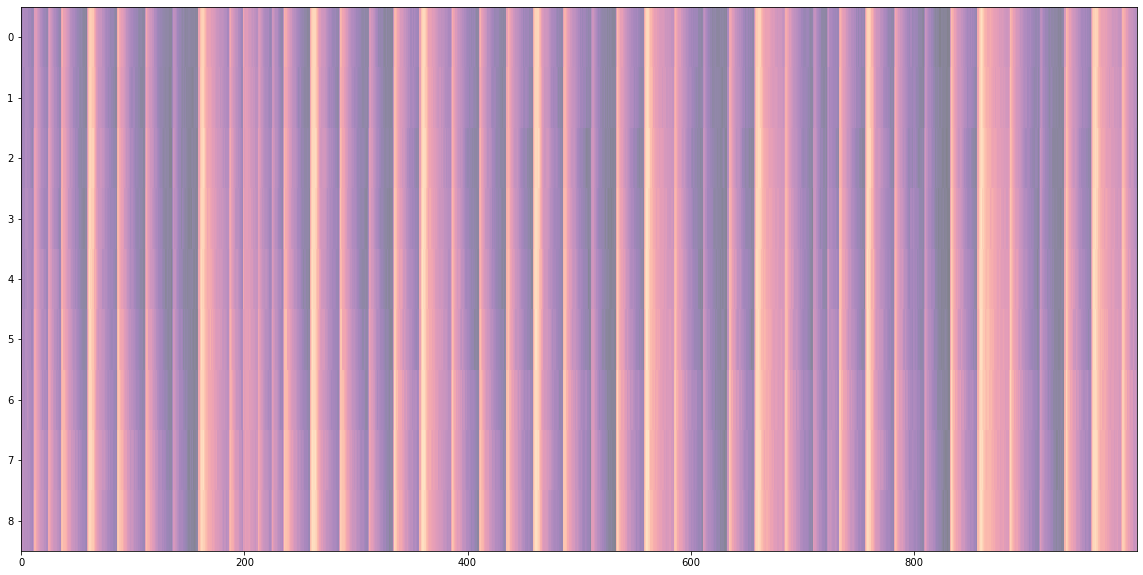

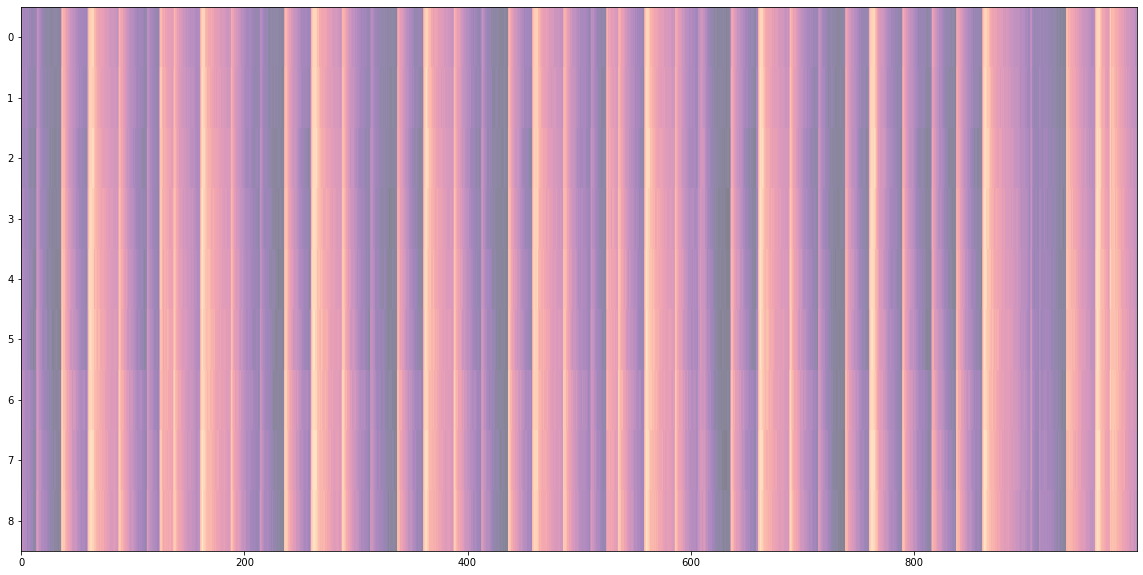

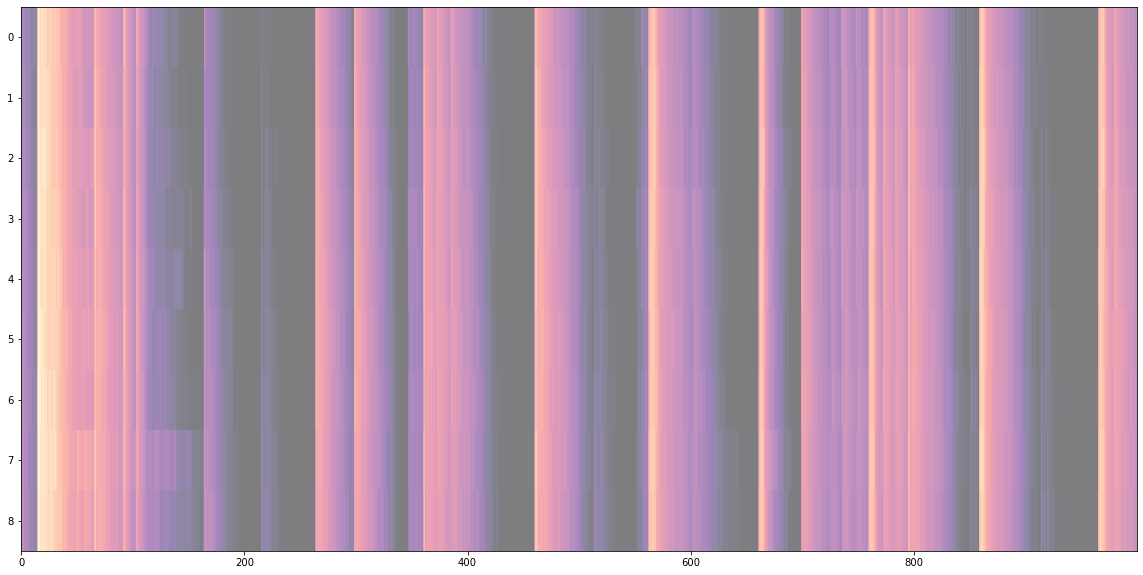

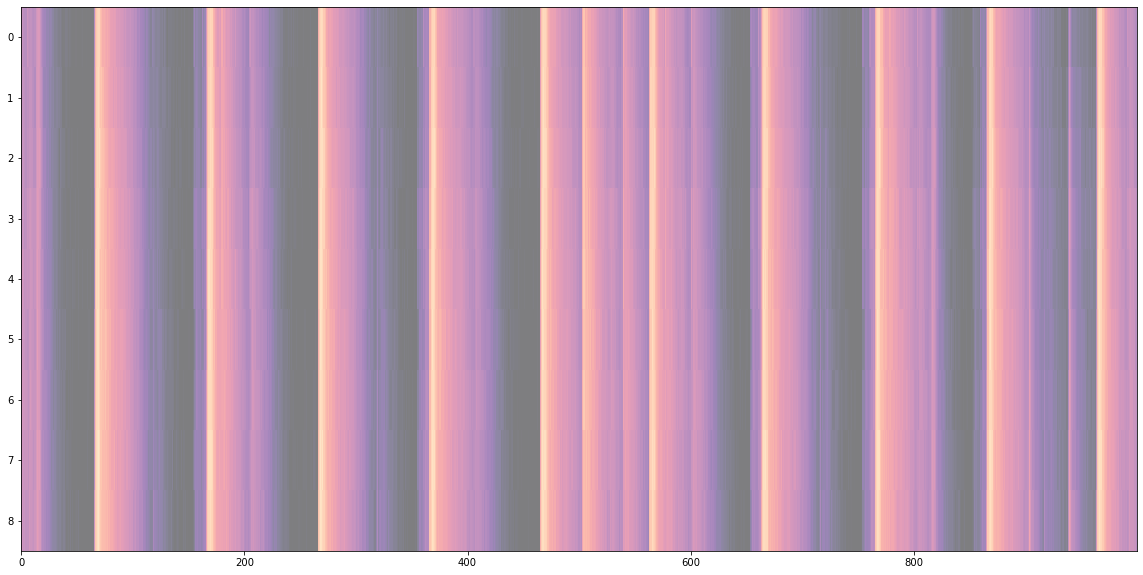

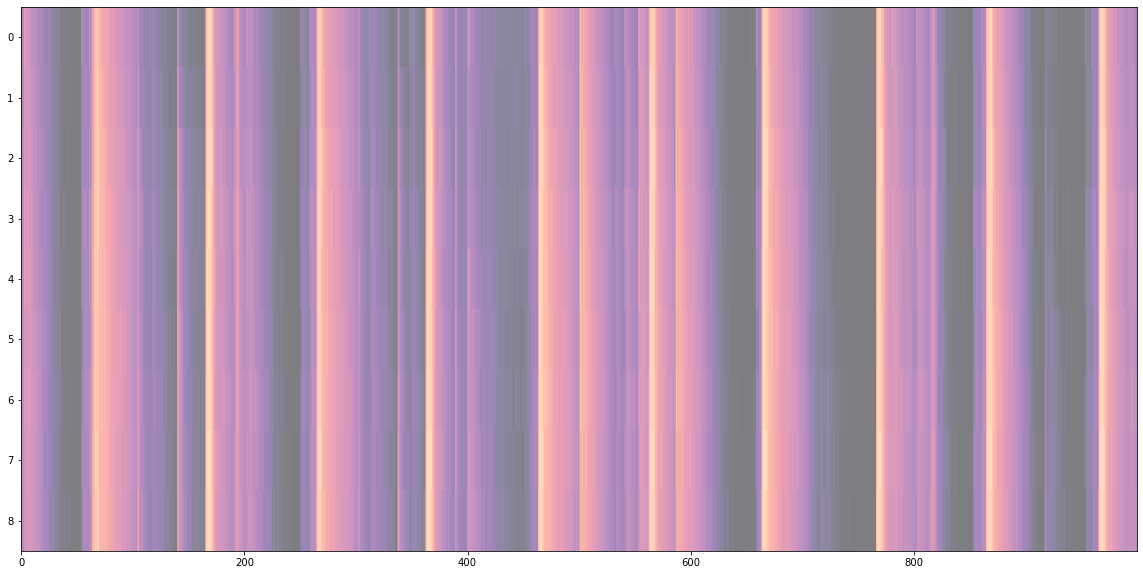

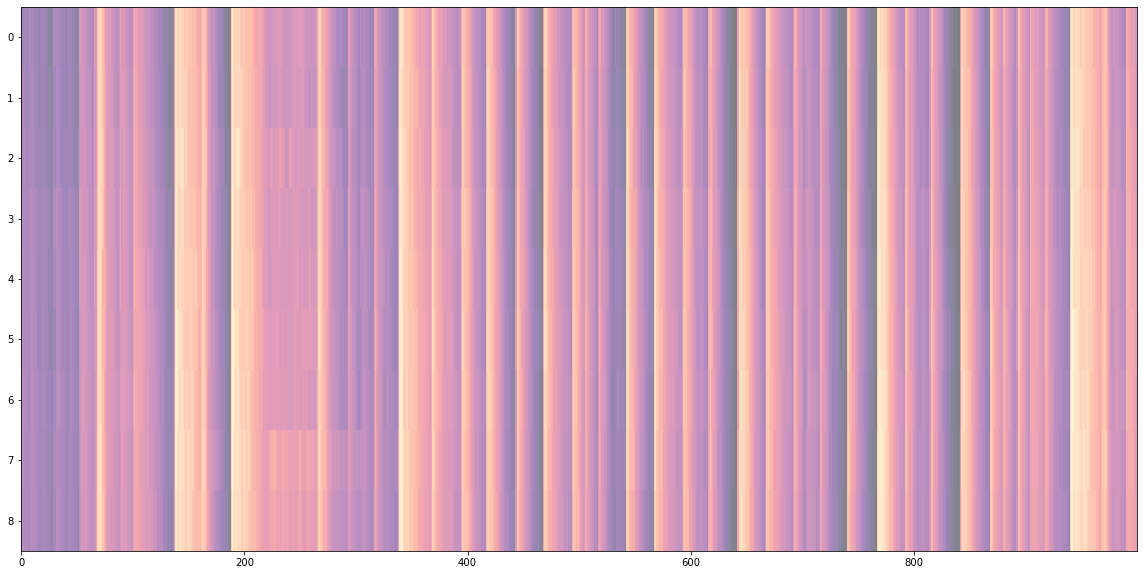

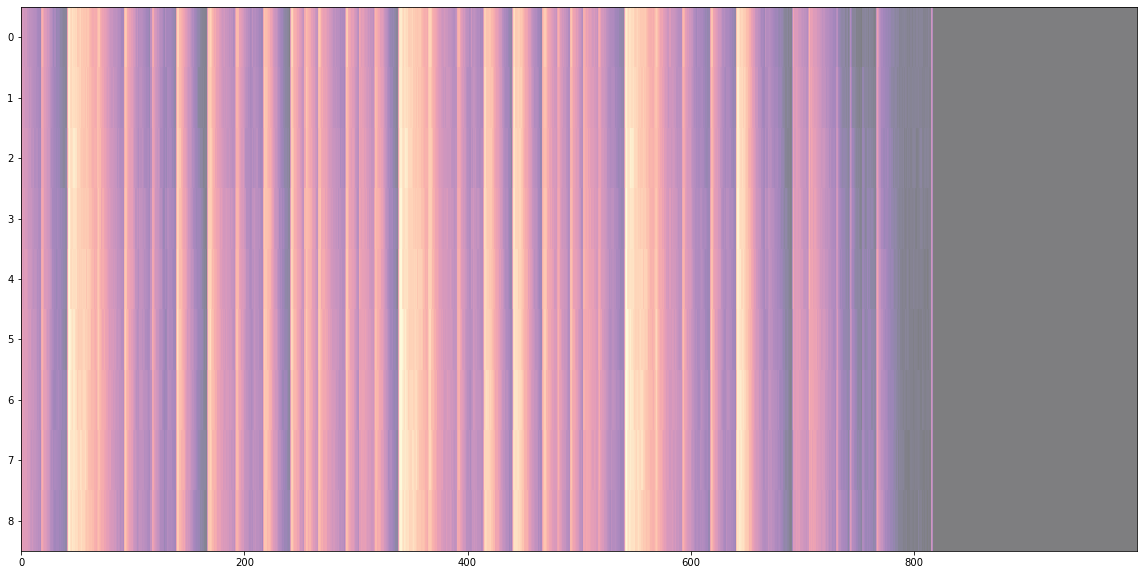

4  file:  drummer1/session1/102_funk_95_beat_4-4.wav   224.807558  sec
zeros_padded_sec:  4.998004535147392


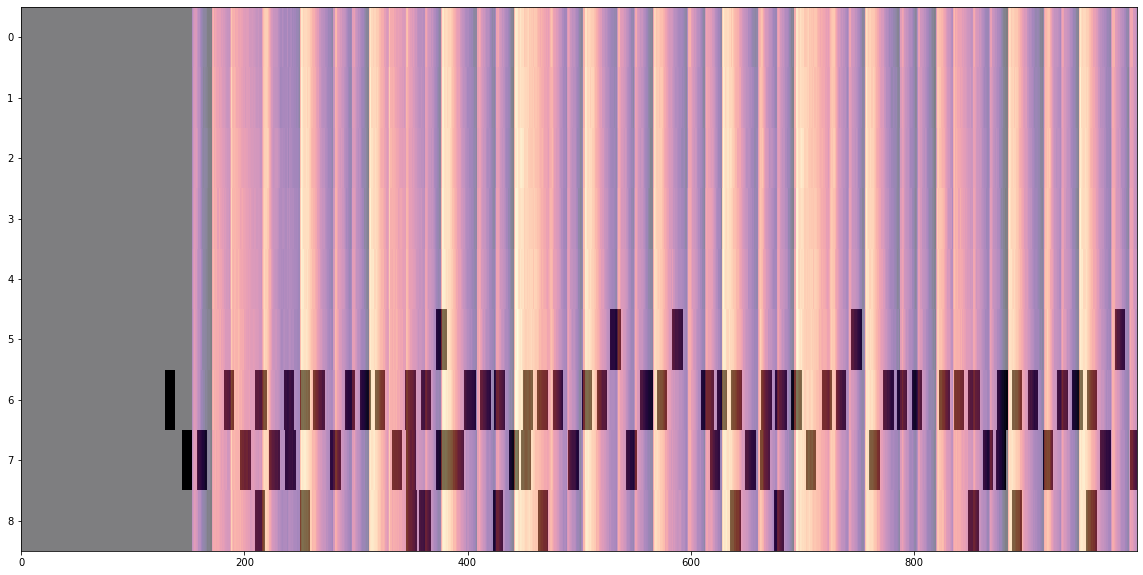

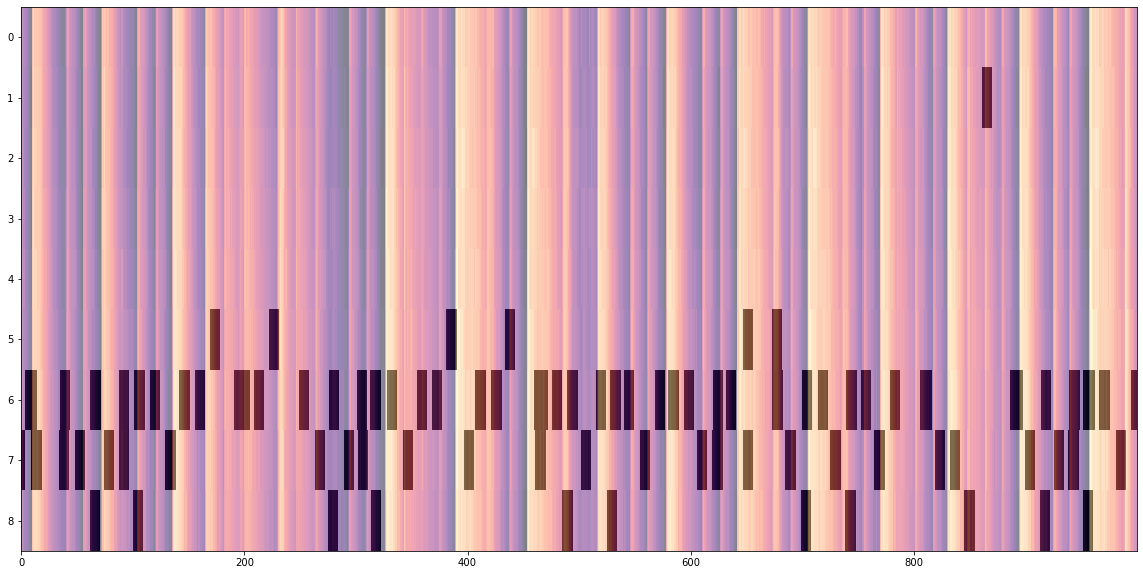

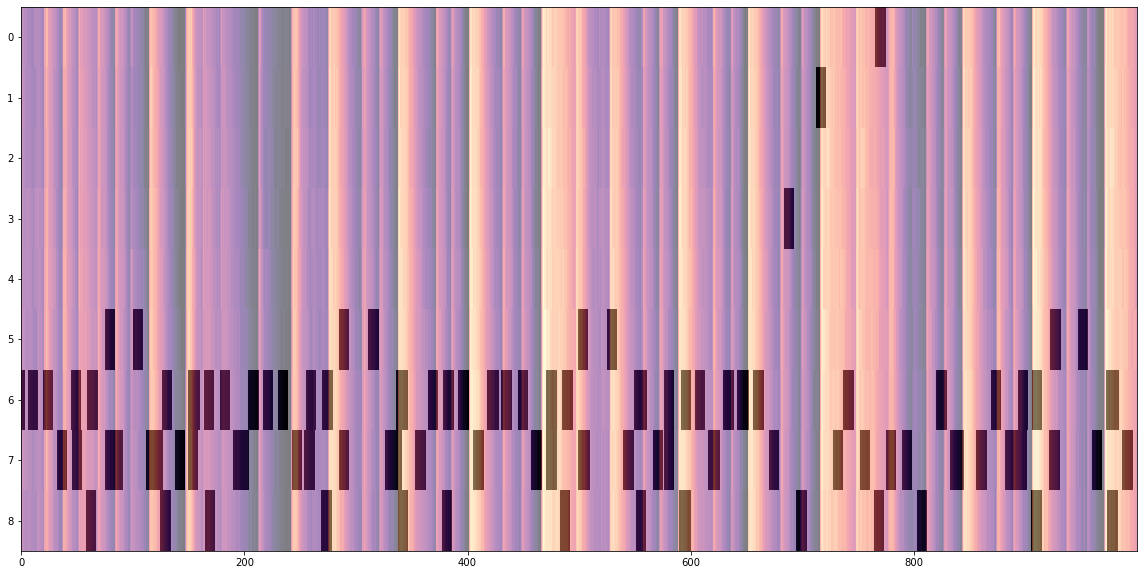

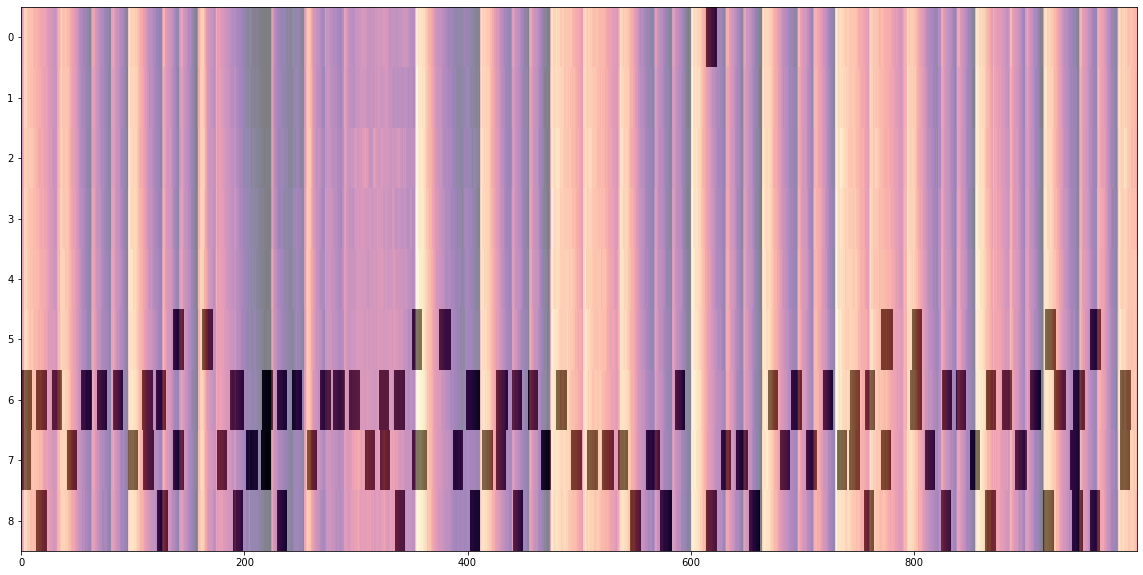

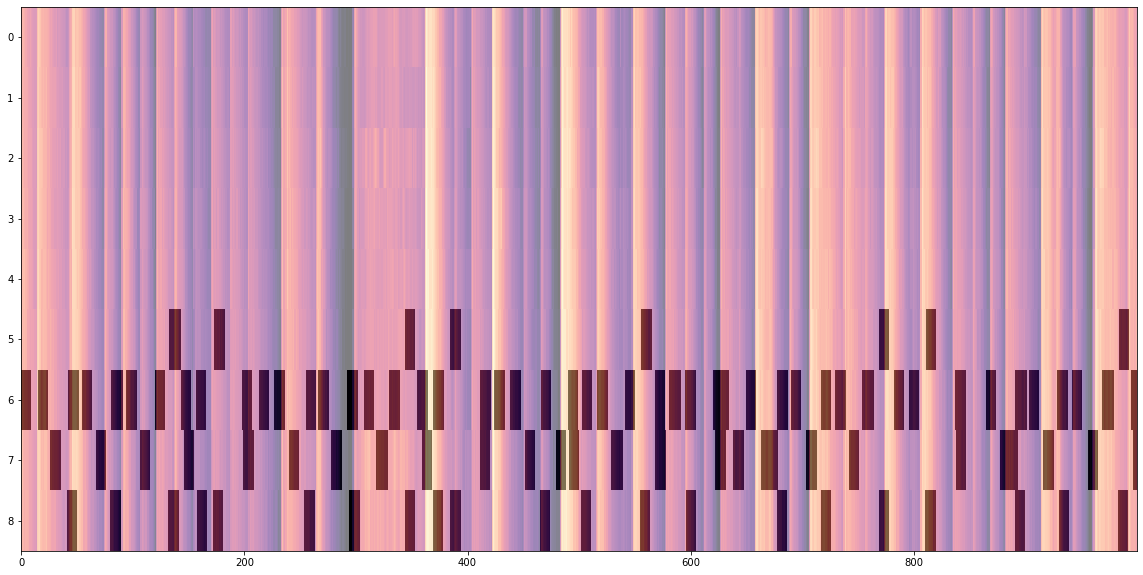

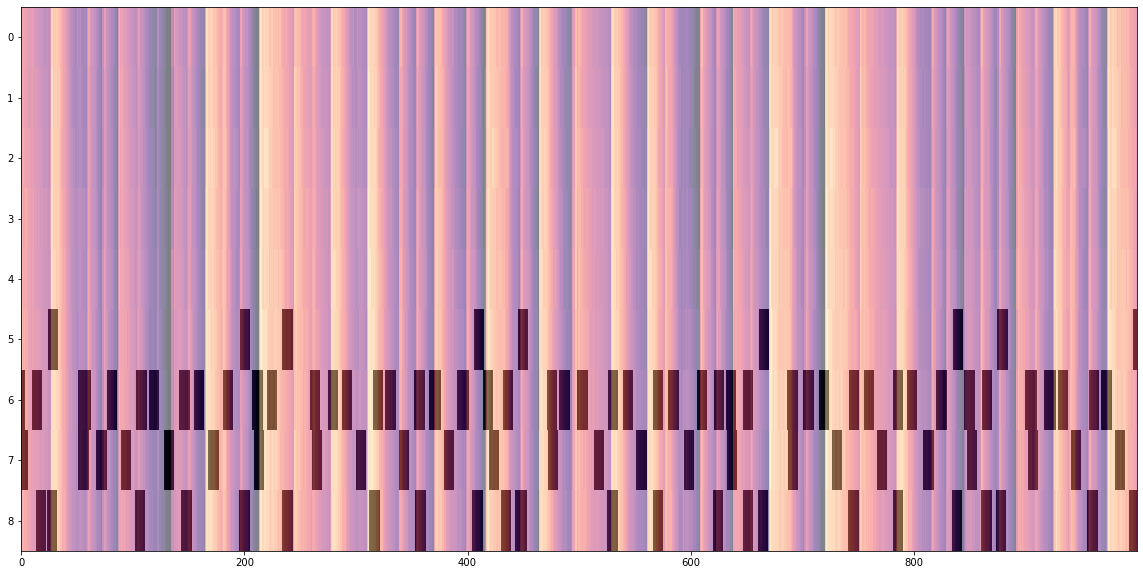

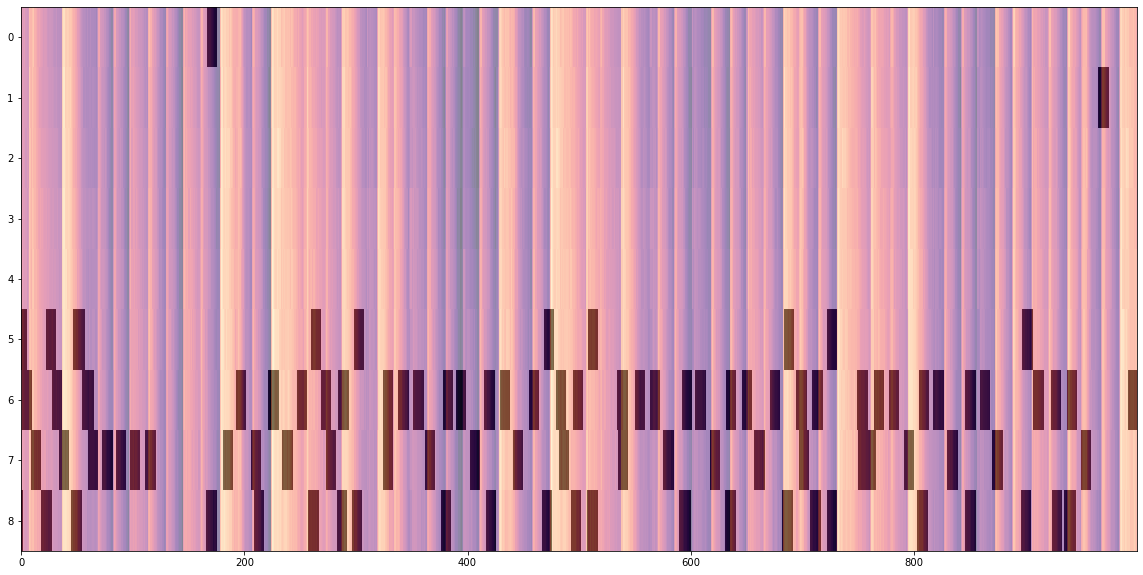

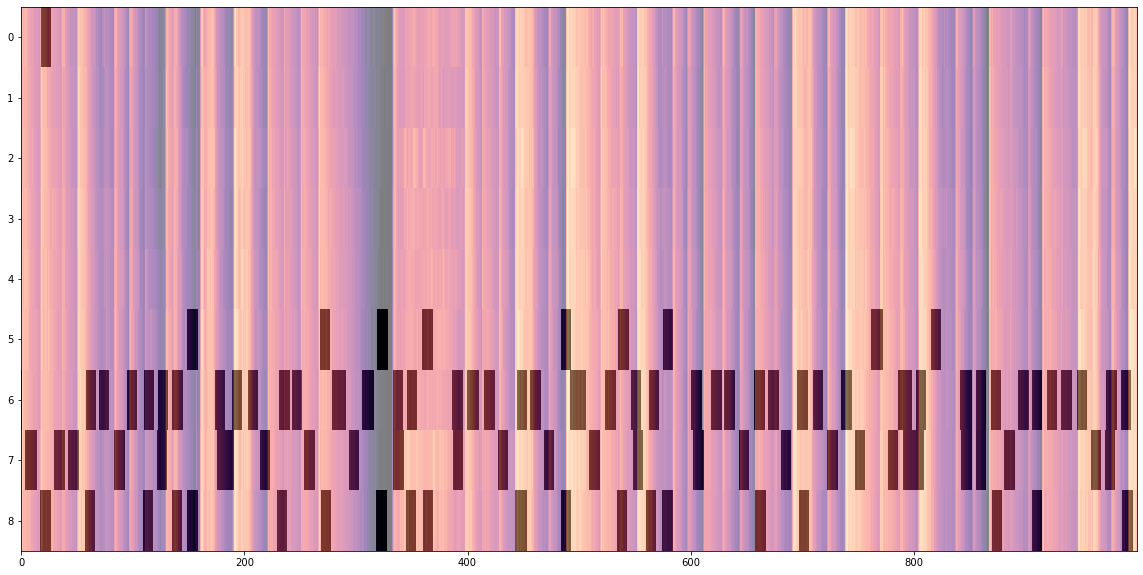

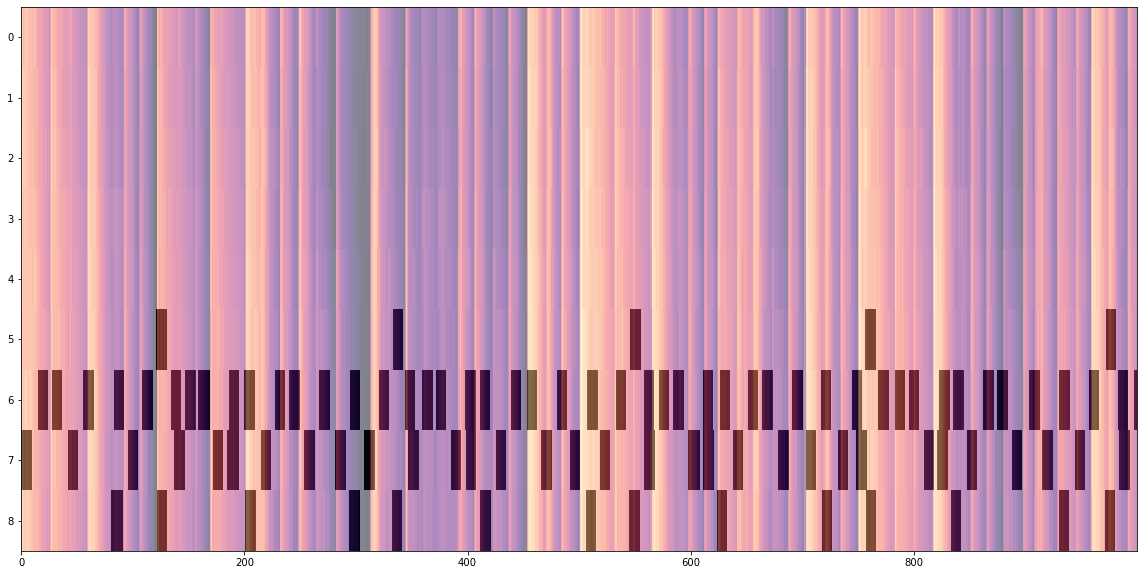

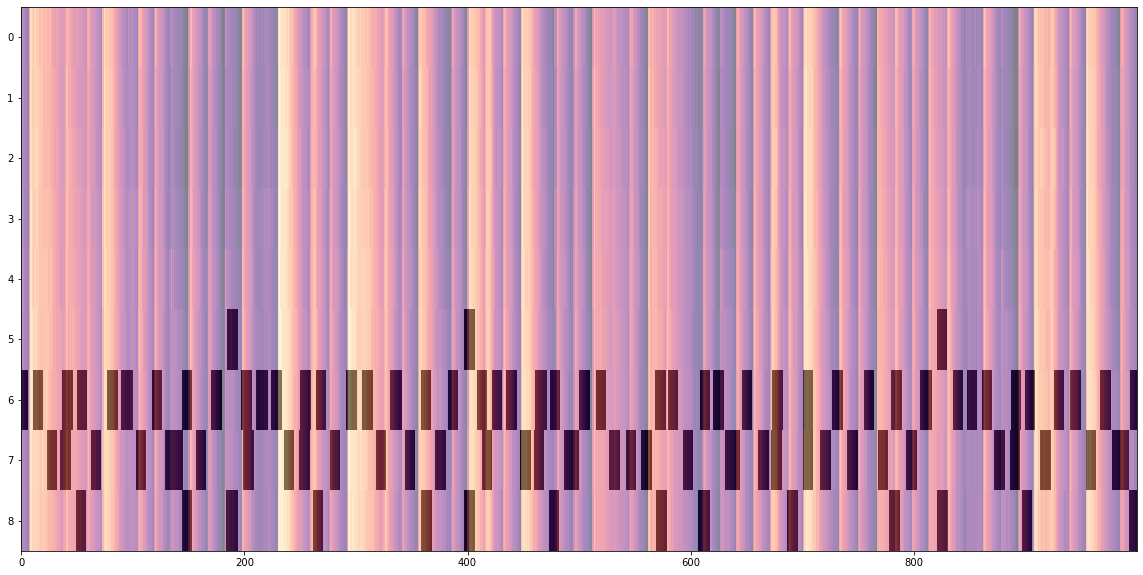

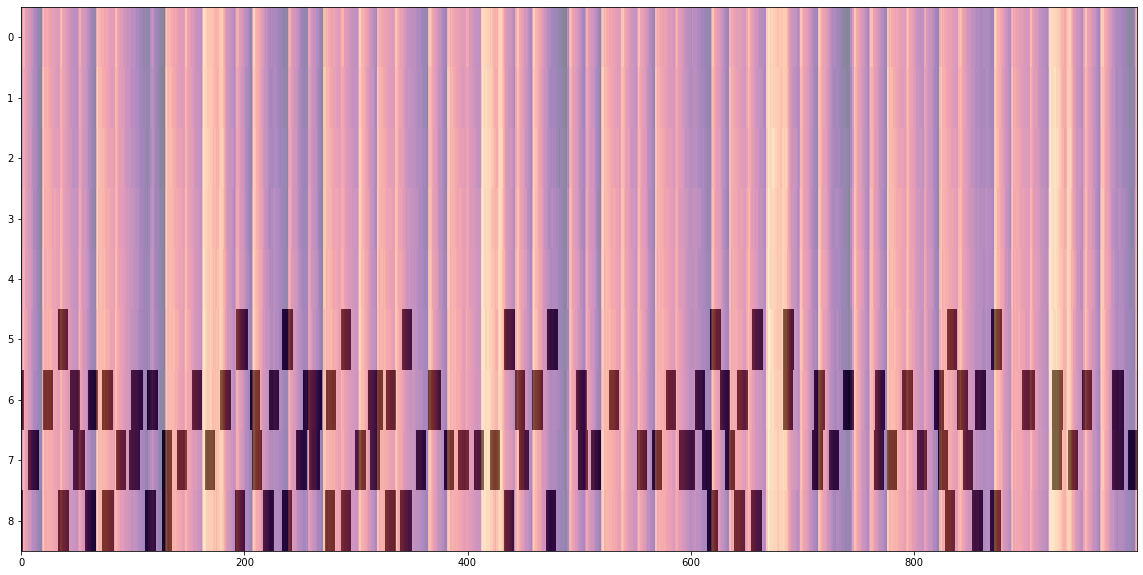

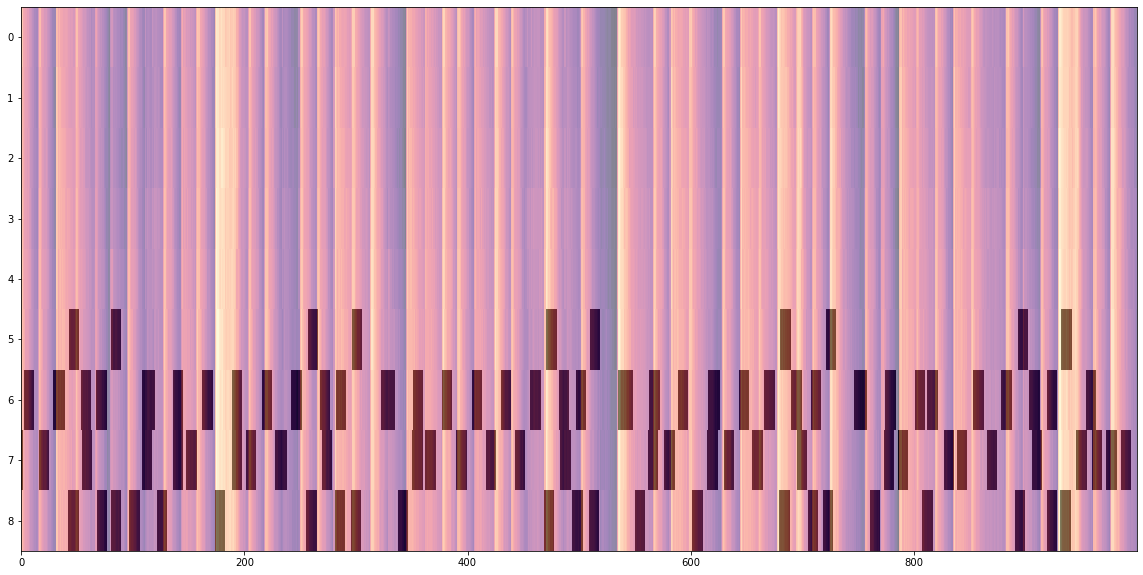

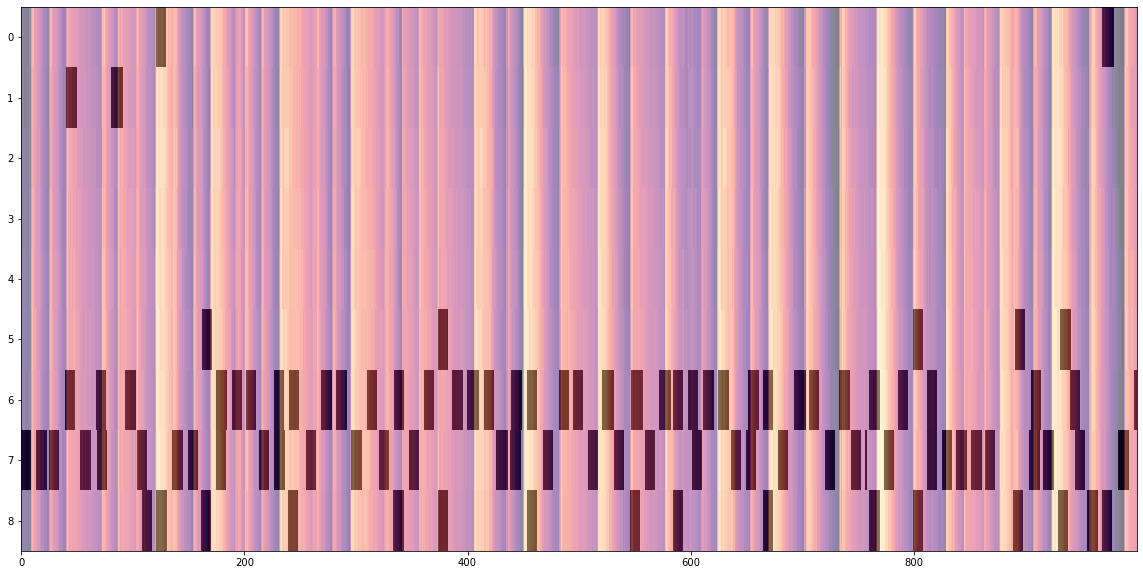

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [150]:
# 3.0 run dataset creation loops - save to file

np.set_printoptions(threshold=sys.maxsize)

# reset temp folder
reset_temp_folder()

#########################################
#                                       #
#           TRAINING DATA               #
#                                       #
#########################################

# get complete list of train feats / labels
print ("starting training dataset creation...")
startTime = time.time()
train_feats = []
train_labels = []
for i, index in enumerate(train_csv):
    print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index)
    for j in range(len(feats)):
        #print ("\t", j, " feats: ", feats[j].shape, " labels: ", labels[j].shape)
        show_midi_over_spec(feats[j], labels[j])
        train_feats.append(feats[j])
        train_labels.append(labels[j])
# make into numpy arrays
train_feats = np.array(train_feats, dtype='float64')
train_labels = np.array(train_labels, dtype='int64')
print ("train_feats.shape: ", train_feats.shape)
print ("train_labels.shape: ", train_labels.shape)
# dataset complete
print ("training dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/train_feats.npy", train_feats, allow_pickle=True)
np.save("data/train_labels.npy", train_labels, allow_pickle=True)

#########################################
#                                       #
#               TEST DATA               #
#                                       #
#########################################

# get complete list of test feats / labels
print ("starting test dataset creation...")
startTime = time.time()
test_feats = []
test_labels = []
for i, index in enumerate(test_csv):
    print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index)
    for j in range(len(feats)):
        test_feats.append(feats[j])
        test_labels.append(labels[j])
# make into numpy arrays
test_feats = np.array(test_feats, dtype='float64')
test_labels = np.array(test_labels, dtype='int64')
print ("test_feats.shape: ", test_feats.shape)
print ("test_labels.shape: ", test_labels.shape)
# dataset complete
print ("test dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/test_feats.npy", test_feats, allow_pickle=True)
np.save("data/test_labels.npy", test_labels, allow_pickle=True)

#########################################
#                                       #
#           VALIDATION DATA             #
#                                       #
#########################################

# # get complete list of validation feats / labels
print ("starting validation dataset creation...")
startTime = time.time()
val_feats = []
val_labels = []
for i, index in enumerate(validation_csv):
    print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index)
    for j in range(len(feats)):
        val_feats.append(feats[j])
        val_labels.append(labels[j])
# make into numpy arrays
val_feats = np.array(val_feats, dtype='float64')
val_labels = np.array(val_labels, dtype='int64')
print ("val_feats.shape: ", val_feats.shape)
print ("val_labels.shape: ", val_labels.shape)
# dataset complete
print ("validation dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/val_feats.npy", val_feats, allow_pickle=True)
np.save("data/val_labels.npy", val_labels, allow_pickle=True)

# reset temp folder
reset_temp_folder()